# `DMKDE` performance on `pot_3`

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

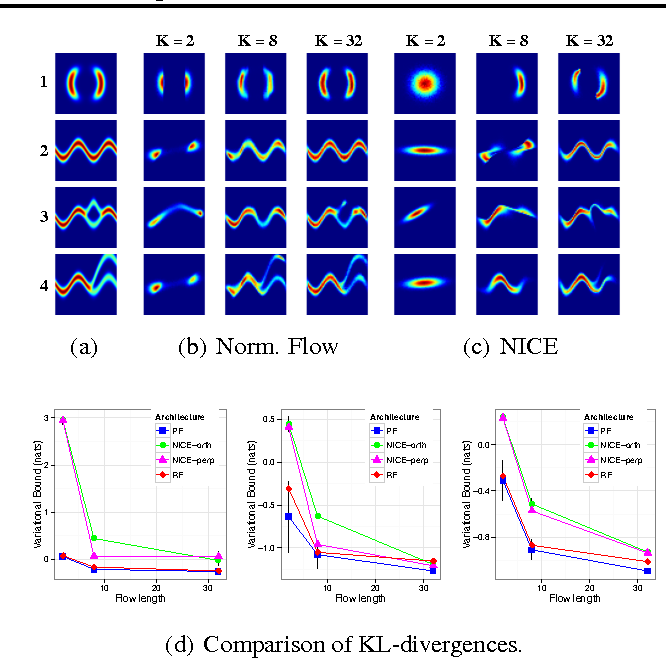

In [2]:
from IPython import display
display.Image("https://d3i71xaburhd42.cloudfront.net/0f899b92b7fb03b609fee887e4b6f3b633eaf30d/7-Figure3-1.png", width =666*0.5, height =658*0.5)

## About the libraries we need

Install `qmc`

Let´s install (git clone to the file system of the Colab VM) the module `qmc` which contains
> Custom models inherited from the super class `tf.keras.Model`.

> Custom layers inherited from the super class `tf.keras.layers.Layer`.

More information on customization when using `tf` this can be found at [here](https://www.tensorflow.org/tutorials/customization/custom_layers#models_composing_layers).

In [3]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 516, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 516 (delta 46), reused 37 (delta 37), pack-reused 439
Receiving objects: 100% (516/516), 37.05 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (235/235), done.


Install `KDEpy`

In [4]:
pip install KDEpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 420 kB 4.9 MB/s 


Install `fastKDE`

In [5]:
pip install fastkde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 952 kB 4.8 MB/s 


General ones that include:

- `pandas` : For managing dataframes that come from txt files.
- `numpy` : For managing multidimensional arrays.
- `pylab` : For plotting purposes.

In [6]:
import pandas as pd
import numpy as np
import pylab as pl
from typeguard import typechecked
import tensorflow_probability as tfp
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
import tensorflow as tf
import qmc.tf.layers as layers
import qmc.tf.models as models
from scipy.stats import norm, bernoulli, gaussian_kde
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from KDEpy import NaiveKDE
from KDEpy import TreeKDE
from KDEpy import FFTKDE
from fastkde import fastKDE
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import seaborn as sns

 Clone repo for sampling made with Pytorch

In [7]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R nf
    !git clone https://github.com/VishakhG/normalizing-flows nf
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'nf': No such file or directory
Cloning into 'nf'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 49 (delta 12), reused 48 (delta 11), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [8]:
import nf.src.densities as densitiesnf
import nf.src.normalizing_flows as nfs
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable

In [9]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

## Auxiliary functions

Potential functions

In [ ]:
"""
Potential functions U(x) from Rezende et al. 2015
p(z) is then proportional to exp(-U(x)).
Since we log this value later in the optimized bound,
no need to actually exp().
"""

def w_1(z):
    return tf.sin((2 * np.pi * z[:, 0]) / 4)


def w_2(z):
    return 3 * tf.exp(-.5 * ((z[:, 0] - 1) / .6) ** 2)


def sigma(x):
    return 1 / (1 + tf.exp(- x))


def w_3(z):
    return 3 * sigma((z[:, 0] - 1) / .3)


def pot_3(z):
    term_1 = tf.exp(-.5 * (
        (z[:, 1] - w_1(z)) / .35) ** 2)
    term_2 = tf.exp(-.5 * (
        (z[:, 1] - w_1(z) + w_2(z)) / .35) ** 2)
    u = - tf.math.log(term_1 + term_2 + 1e-7)
    return tf.exp(- u)/ 13.934

Plot potential function

In [ ]:
def plot_pot_func(pot_func, ax=None):
    if ax is None:
        _, ax = plt.subplots(1)
    x = np.linspace(-4, 4, int(1e2))
    y = np.linspace(-4, 4, int(1e2))
    xx, yy = np.meshgrid(x, y)
    in_tens = tf.constant(np.vstack([xx.ravel(), yy.ravel()]).T)
    z = (tf.exp(pot_func(in_tens))).numpy().reshape(xx.shape)

    cmap = plt.get_cmap('inferno')
    ax.contourf(x, y, z.reshape(xx.shape), cmap=cmap)

Constant for `DMKDE` and `EIG_DMKDE` predictions

In [ ]:
def calculate_constant_qmkde(gamma=1, dimension = 1):
  sigma = (4*gamma)**(-1/2)
  coefficient = 1 /  (2*np.pi*sigma**2)**(dimension/2)
  return coefficient

Define `raw_kde` method 

In [ ]:
def raw_kde(x_test, x_train, gamma = 1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  coefficient = 1 /  (2*np.pi*sigma**2)**(x_train.shape[1]/2) 
  constant_outside = 1/(x_train.shape[0]) * coefficient
  result = constant_outside * np.sum(exponential)  
  return result

## Data

Energy functions from `Variational Inference with Normalizing Flows`
***

See the article [here](http://proceedings.mlr.press/v37/rezende15.pdf) where the distribution of the data is given by the following equations:

1.
$$
\frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^{2}-\ln \left(e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{1}-2}{0.6}\right]^{2}}+e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{1}+2}{0.6}\right]^{2}}\right)
$$
2.
$$
\frac{1}{2}\left[\frac{\mathbf{z}_{2}-w_{1}(\mathbf{z})}{0.4}\right]^{2}
$$
3.
$$
\boxed{
-\ln \left(e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{2}-w_{1}(\mathbf{z})}{0.35}\right]^{2}}+e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{2}-w_{1}(\mathbf{z})+w_{2}(\mathbf{z})}{0.35}\right]^{2}}\right)}
$$
4.
$$
-\ln \left(e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{2}-w_{1}(\mathbf{z})}{0.4}\right]^{2}}+e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{2}-w_{1}(\mathbf{z})+w_{3}(\mathbf{z})}{0.35}\right]^{2}}\right)
$$

with $w_{1}(\mathbf{z})=\sin \left(\frac{2 \pi \mathbf{z}_{1}}{4}\right), w_{2}(\mathbf{z})=3 e^{-\frac{1}{2}\left[\frac{\left(\mathbf{z}_{1}-1\right)}{0.6}\right]^{2}}, w_{3}(\mathbf{z})=3 \sigma\left(\frac{\mathbf{z}_{1}-1}{0.3}\right) \text { and } \sigma(x)=\frac{1}{\left(1+e^{-x}\right)}$. 

Sample size - Do not run

In [ ]:
sample_size = 1000000

Generate the sample in an 'unbounded' setup - Do not run

In [ ]:
@tf.function
def unnormalized_log_prob(x):  
  x = tf.reshape(x, (1,-1))
  res = pot_1(x)
  return res

# Initialize the HMC transition kernel.
num_results = int(sample_size)
num_burnin_steps = int(300)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=200,
        #unrolled_leapfrog_steps=2,
        state_gradients_are_stopped=False,
        step_size=np.array([0.01, 0.01])),
    num_adaptation_steps=int(num_burnin_steps * 0.9),
      target_accept_prob = 0.75)

# Run the chain (with burn-in).
@tf.function
def run_chain():
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=tf.constant([[-2.0,0.0]]),
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: [pkr.inner_results.is_accepted, 
                               #pkr.inner_results.accepted_results.step_size,
                             pkr.inner_results.log_accept_ratio])
  return samples, is_accepted

samples, is_accepted = run_chain()

In [ ]:
X = samples.numpy().reshape(num_results,2)

In [ ]:
X.shape

Save data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#np.savetxt(fname="/content/drive/MyDrive/UniversidadNacional/Thesis/Datasets/NF1/NF1_1M.csv", delimiter=" ", X = X)

Load data

In [ ]:
X = np.load("/content/drive/MyDrive/UniversidadNacional/Thesis/Datasets/NF3/nf3.npy")

In [ ]:
X.shape

(157367, 2)

Plot of Potential 1 vs. Samples

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


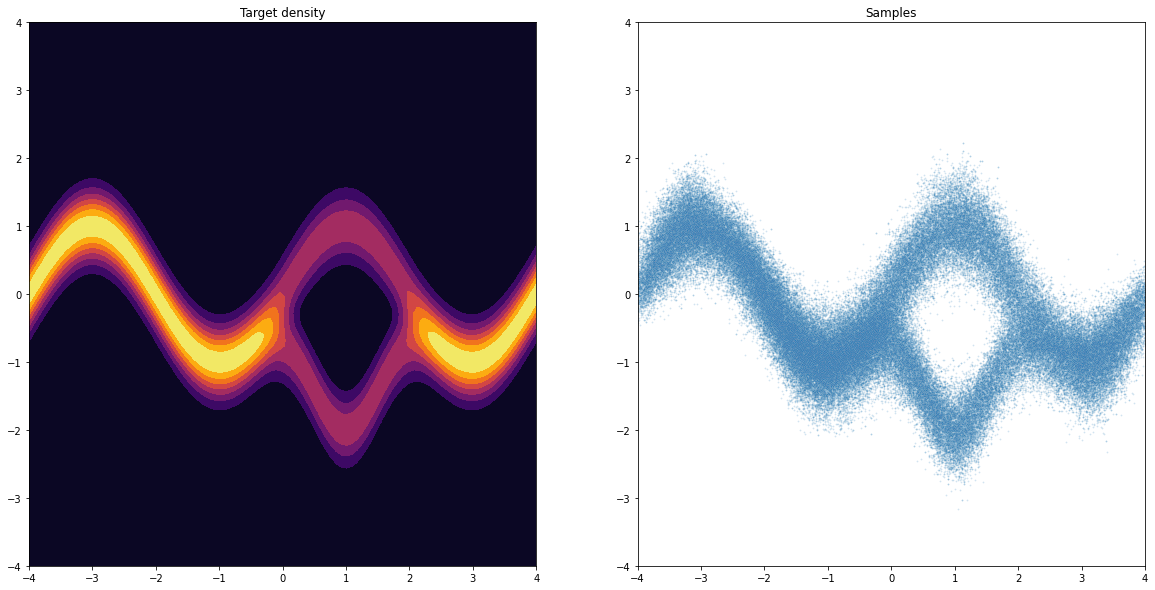

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(pot_3, ax = axes[0]) 
axes[0].set_title('Target density')
axes[1].set_xlim([-4,4])
axes[1].set_ylim([-4,4])
sns.scatterplot(X[:, 0], X[:, 1], alpha=.2, s = 3 ,ax=axes[1])
axes[1].set_title('Samples')
plt.show()

True densities

In [ ]:
X_densities = pot_3(X).numpy()

In [ ]:
X.shape

(157367, 2)

In [ ]:
X_densities.shape

(157367,)

Scatter plot of the data

In [ ]:
plt.rcParams["figure.figsize"] = (20*0.25,15*0.25)

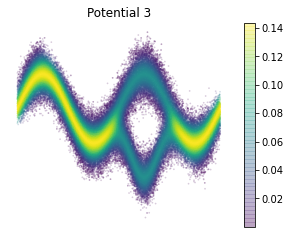

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X[:,0], X[:,1], c = X_densities , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('Potential 3')
plt.yticks([])
plt.xticks([])
plt.savefig('alldensities_pot3.png',dpi = 300)
plt.show()

Histogram of distances with 1000 samples - Do not run



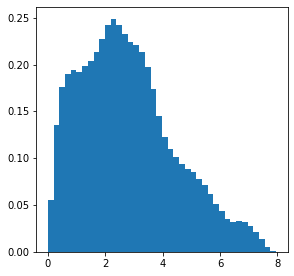

In [ ]:
distances_X = euclidean_distances(X[:1000],X[:1000])
plt.hist(distances_X[np.triu_indices_from(distances_X, k=1)].ravel(), density = True, bins=40);

We suggest a `bw = 2.5`.



## Experiment 1 : 10

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 10, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(10, 2) and their densities shape is (10,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

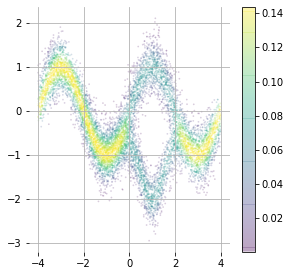

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = pot_3(X_test_new).numpy()
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:2 with L1_error 0.05026825830060845


Fixed gamma

In [ ]:
gamma = 2

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.5

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 269 ms, sys: 0 ns, total: 269 ms
Wall time: 269 ms


Scatter plot

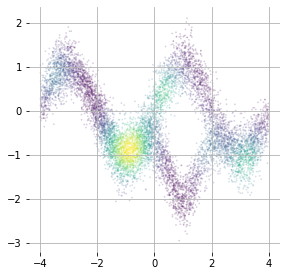

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.05034388550393431

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 13.7 ms, sys: 0 ns, total: 13.7 ms
Wall time: 14.8 ms


Scatter plot

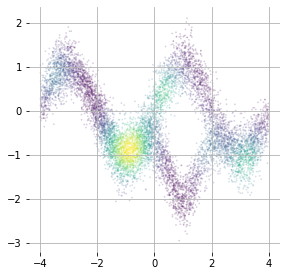

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.05034388558323307

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 4.8 s, sys: 133 ms, total: 4.93 s
Wall time: 4.77 s


Scatter plot

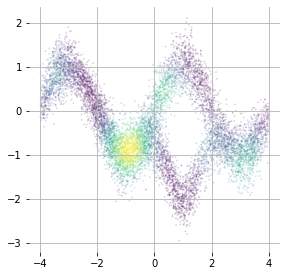

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.05035126389409076

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 8.14 ms, sys: 2.95 ms, total: 11.1 ms
Wall time: 10.8 ms


Scatter plot

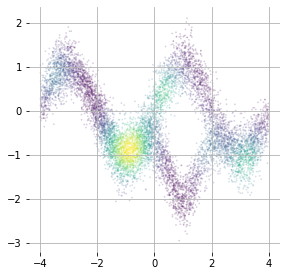

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.05034388558323315

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 13 ms, sys: 220 µs, total: 13.2 ms
Wall time: 15 ms


Scatter plot

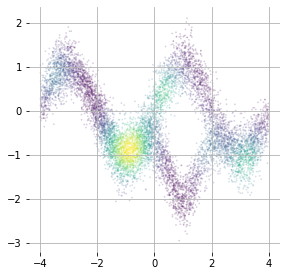

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.05034388558323315

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 7.43 s, sys: 3.36 ms, total: 7.44 s
Wall time: 7.43 s


Scatter plot

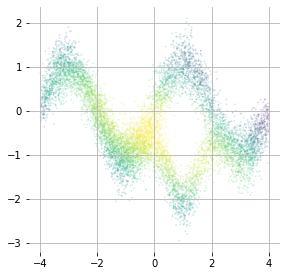

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.05899017412015321

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

1/1 [==============================] - 3s 3s/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 849 ms, sys: 96 ms, total: 945 ms
Wall time: 964 ms


Scatter plot 

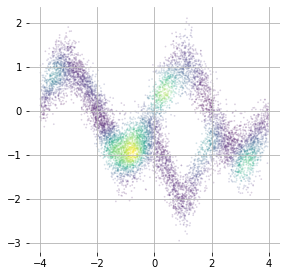

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.05958331909179688

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

1/1 [==============================] - 0s 98ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 2.01 s, sys: 146 ms, total: 2.16 s
Wall time: 1.65 s


Scatter plot 

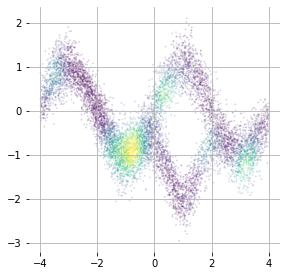

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.064065673828125

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

1/1 [==============================] - 0s 96ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1min 48s, sys: 2.14 s, total: 1min 50s
Wall time: 59.6 s


Scatter plot 

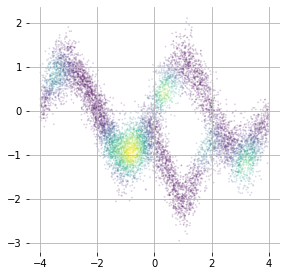

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.06446504516601563

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

1/1 [==============================] - 0s 99ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 12min 46s, sys: 8.77 s, total: 12min 55s
Wall time: 6min 43s


Scatter plot 

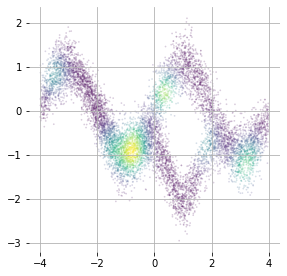

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.06442227172851563

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

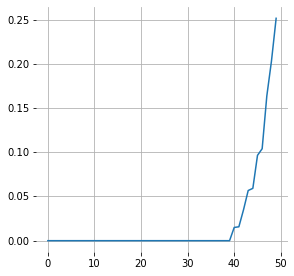

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 711 ms, sys: 80.5 ms, total: 792 ms
Wall time: 650 ms


Scatter plot 

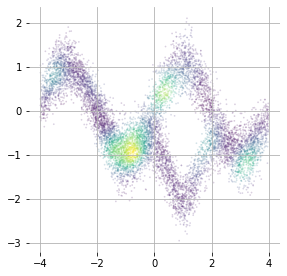

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.0595833251953125

##### dim = 100

Train

In [ ]:
num_eig = 50
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

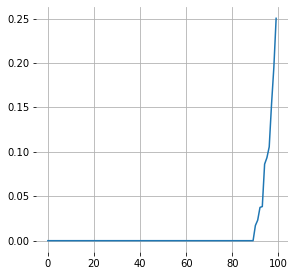

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 591 ms, sys: 65.7 ms, total: 656 ms
Wall time: 768 ms


Scatter plot 

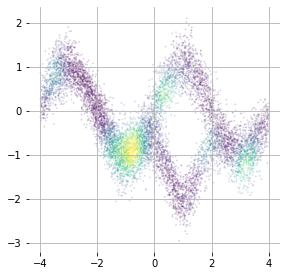

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.06406566162109376

##### dim = 500

Train

In [ ]:
num_eig = 50
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

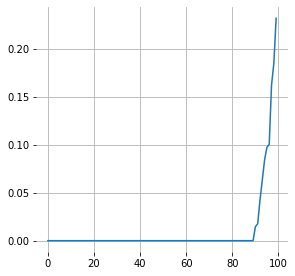

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 651 ms, sys: 62.7 ms, total: 714 ms
Wall time: 771 ms


Scatter plot 

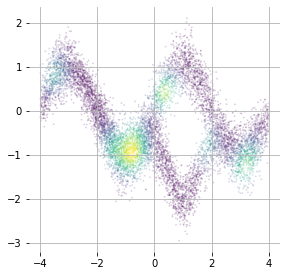

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.06446622314453125

##### dim = 1000

Train

In [ ]:
num_eig = 50
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

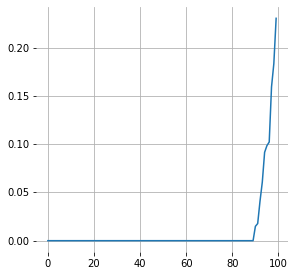

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 880 ms, sys: 79.1 ms, total: 959 ms
Wall time: 779 ms


Scatter plot 

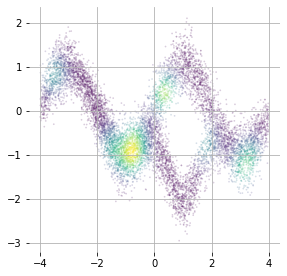

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.06443289184570312

## Experiment 2 : 100

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 100, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(100, 2) and their densities shape is (100,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

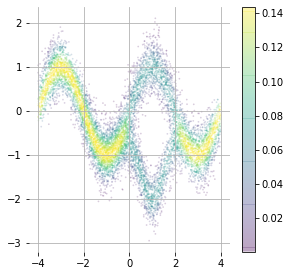

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = pot_3(X_test_new).numpy()
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:8 with L1_error 0.0314826476353402


Fixed gamma

In [ ]:
gamma = 8

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.25

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 336 ms, sys: 4 ms, total: 340 ms
Wall time: 340 ms


Scatter plot

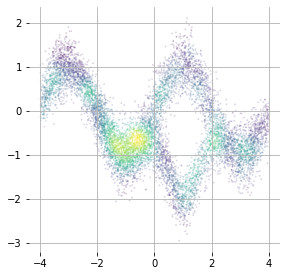

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.03327421690118173

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 110 ms, sys: 3.89 ms, total: 113 ms
Wall time: 117 ms


Scatter plot

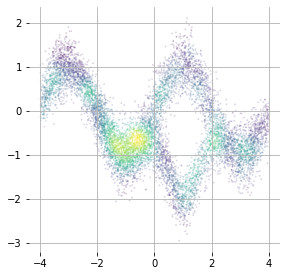

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.03327421701195262

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 5 s, sys: 95.6 ms, total: 5.1 s
Wall time: 5.01 s


Scatter plot

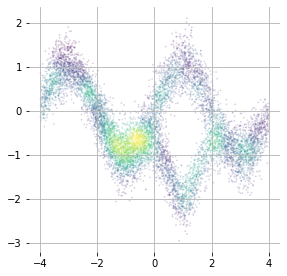

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.03327513041677673

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 67.5 ms, sys: 2 ms, total: 69.5 ms
Wall time: 69.8 ms


Scatter plot

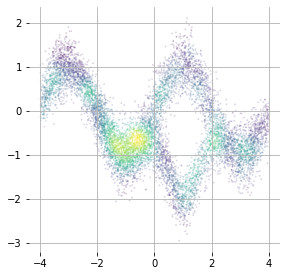

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.03327421701195266

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 68.4 ms, sys: 1 µs, total: 68.4 ms
Wall time: 68.2 ms


Scatter plot

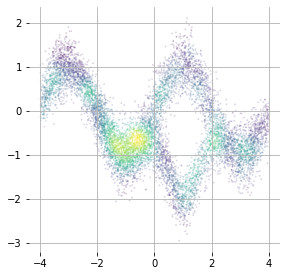

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.03327421701195267

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 15 s, sys: 34.9 ms, total: 15.1 s
Wall time: 15 s


Scatter plot

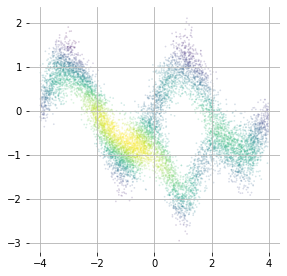

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.04325479274329229

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

4/4 [==============================] - 0s 3ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 824 ms, sys: 566 ms, total: 1.39 s
Wall time: 1.34 s


Scatter plot 

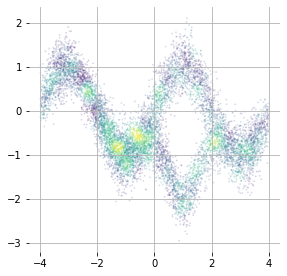

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.078540234375

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

4/4 [==============================] - 0s 3ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 2.1 s, sys: 429 ms, total: 2.53 s
Wall time: 2 s


Scatter plot 

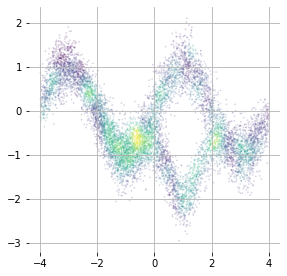

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.06161925659179688

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

4/4 [==============================] - 0s 3ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1min 50s, sys: 2.34 s, total: 1min 53s
Wall time: 1min 1s


Scatter plot 

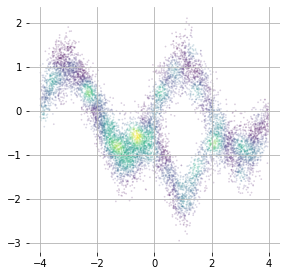

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.03902376708984375

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

4/4 [==============================] - 0s 4ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 12min 57s, sys: 4.89 s, total: 13min 1s
Wall time: 6min 44s


Scatter plot 

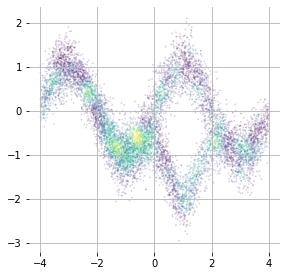

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.03854382934570313

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

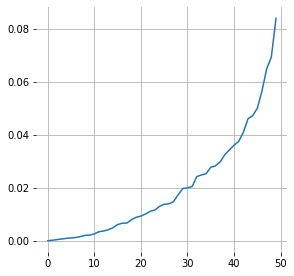

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 600 ms, sys: 50.5 ms, total: 650 ms
Wall time: 776 ms


Scatter plot 

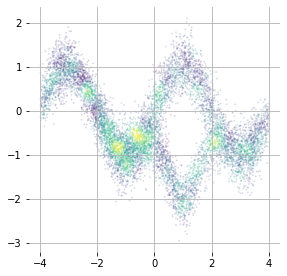

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.078540234375

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

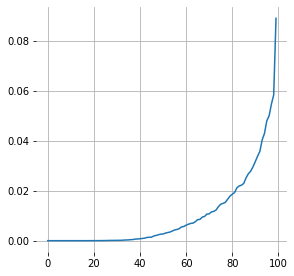

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 604 ms, sys: 67.6 ms, total: 672 ms
Wall time: 770 ms


Scatter plot 

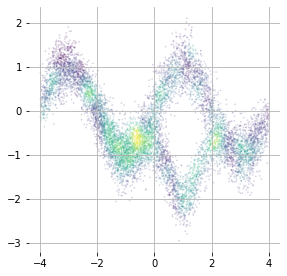

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.061619287109375004

##### dim = 500

Train

In [ ]:
num_eig = 100
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

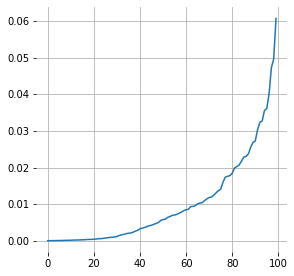

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 892 ms, sys: 97.1 ms, total: 989 ms
Wall time: 715 ms


Scatter plot 

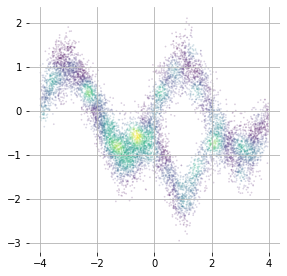

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.039025000000000004

##### dim = 1000

Train

In [ ]:
num_eig = 100
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

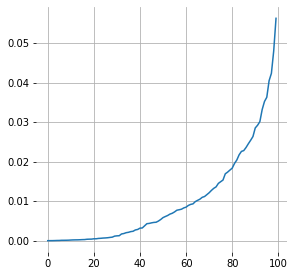

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 1.12 s, sys: 110 ms, total: 1.23 s
Wall time: 847 ms


Scatter plot 

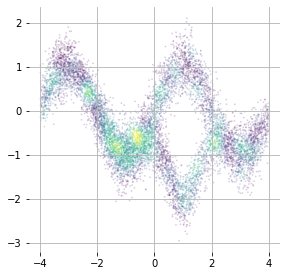

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.03855318603515625

## Experiment 3 : 1000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 1000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(1000, 2) and their densities shape is (1000,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

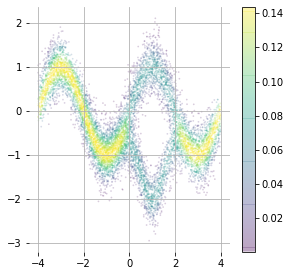

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = pot_3(X_test_new).numpy()
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:16 with L1_error 0.025187391689948373


Fixed gamma

In [ ]:
gamma = 16

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.17677669529663687

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 598 ms, sys: 1.97 ms, total: 600 ms
Wall time: 601 ms


Scatter plot

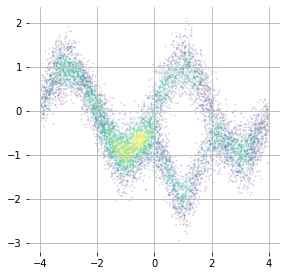

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.025851071198926025

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 981 ms, sys: 2.99 ms, total: 984 ms
Wall time: 992 ms


Scatter plot

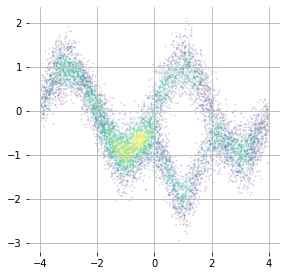

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.025851071389962

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 4.94 s, sys: 61.6 ms, total: 5 s
Wall time: 4.93 s


Scatter plot

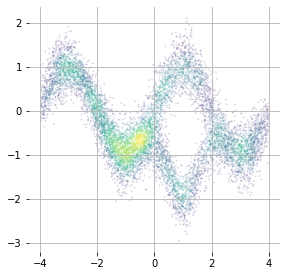

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.025847187098616123

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 524 ms, sys: 1.81 ms, total: 526 ms
Wall time: 526 ms


Scatter plot

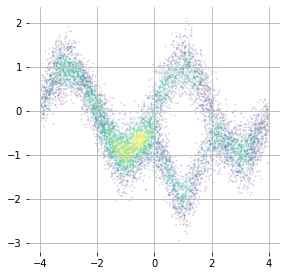

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.02585107138996177

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 550 ms, sys: 2.97 ms, total: 553 ms
Wall time: 554 ms


Scatter plot

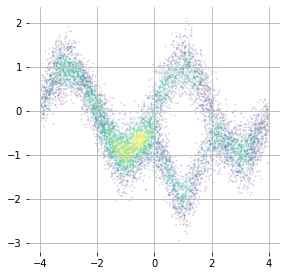

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.025851071389961715

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 14.3 s, sys: 24.3 ms, total: 14.4 s
Wall time: 14.3 s


Scatter plot

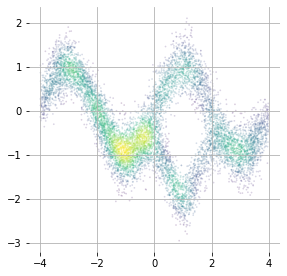

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.026770251088810024

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 4, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

32/32 [==============================] - 0s 1ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = 4, dimension = 2) 

CPU times: user 848 ms, sys: 65.5 ms, total: 914 ms
Wall time: 755 ms


Scatter plot 

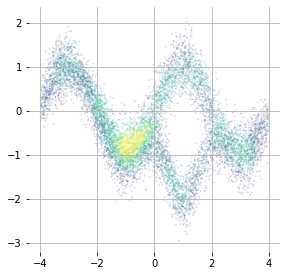

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.036019891357421875

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 4, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

32/32 [==============================] - 0s 1ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = 4, dimension = 2) 

CPU times: user 2.11 s, sys: 200 ms, total: 2.31 s
Wall time: 1.77 s


Scatter plot 

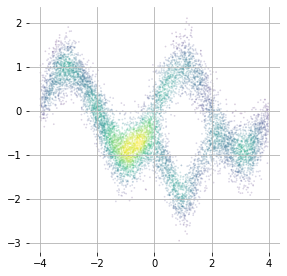

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.03572122192382813

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 4, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

32/32 [==============================] - 0s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = 4, dimension = 2) 

CPU times: user 1min 53s, sys: 3.15 s, total: 1min 56s
Wall time: 1min 3s


Scatter plot 

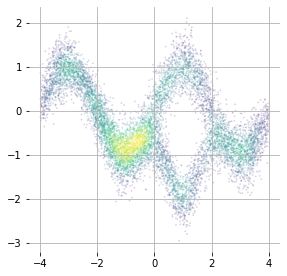

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.025774255371093752

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 4, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

32/32 [==============================] - 0s 4ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = 4, dimension = 2) 

CPU times: user 13min 6s, sys: 6.68 s, total: 13min 13s
Wall time: 6min 51s


Scatter plot 

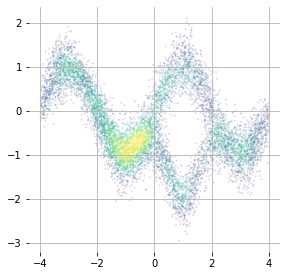

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.025683355712890626

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 4, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

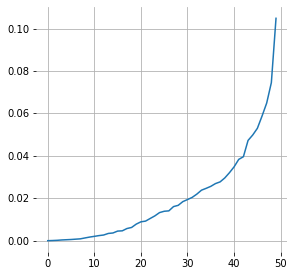

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 4,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 552 ms, sys: 66.5 ms, total: 619 ms
Wall time: 764 ms


Scatter plot 

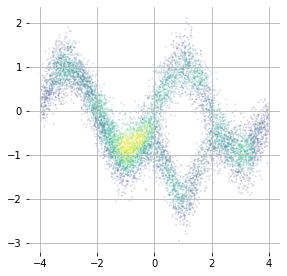

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.0360198974609375

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 4, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

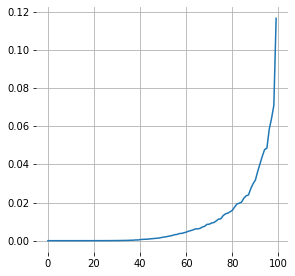

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 4,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 601 ms, sys: 64.6 ms, total: 666 ms
Wall time: 770 ms


Scatter plot 

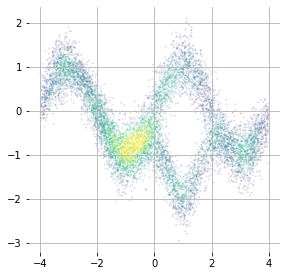

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.03572123718261719

##### dim = 500

Train

In [ ]:
num_eig = 300
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 4, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

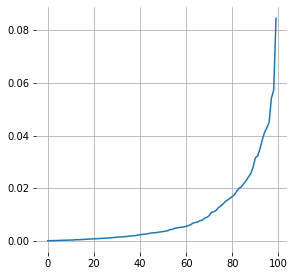

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 4,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 1.94 s, sys: 322 ms, total: 2.26 s
Wall time: 1.57 s


Scatter plot 

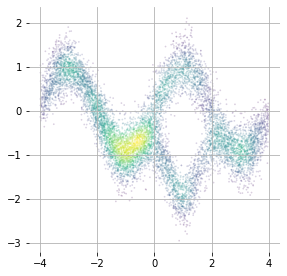

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.025774035644531252

##### dim = 1000

Train

In [ ]:
num_eig = 300
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 4, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

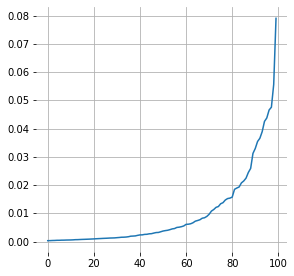

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 4,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 3.05 s, sys: 200 ms, total: 3.25 s
Wall time: 2.02 s


Scatter plot 

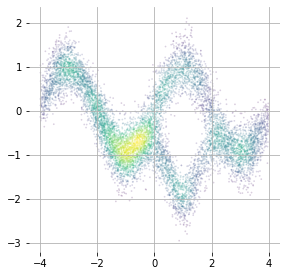

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.025680862426757815

## Experiment 4 : 10000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 10000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

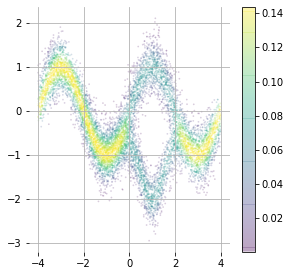

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = pot_3(X_test_new).numpy()
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:32 with L1_error 0.019771328554758084


Fixed gamma

In [ ]:
gamma = 32

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.125

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 3.1 s, sys: 3.65 ms, total: 3.1 s
Wall time: 3.11 s


Scatter plot

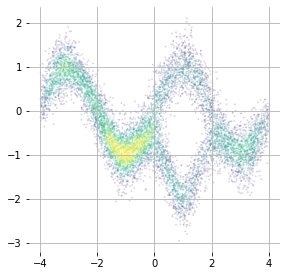

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.019888643955384772

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 7.49 s, sys: 16.9 ms, total: 7.51 s
Wall time: 7.51 s


Scatter plot

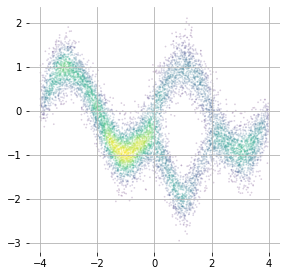

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.019888644033525357

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 5.06 s, sys: 36.1 ms, total: 5.1 s
Wall time: 5.08 s


Scatter plot

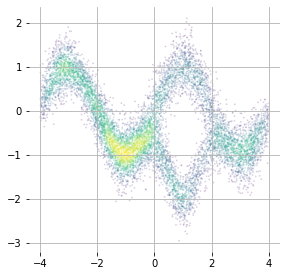

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.019883829619887536

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 2.85 s, sys: 4.43 ms, total: 2.86 s
Wall time: 2.85 s


Scatter plot

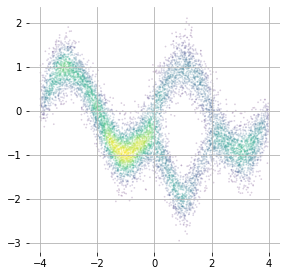

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.019888644033523837

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 3.88 s, sys: 9.17 ms, total: 3.89 s
Wall time: 3.89 s


Scatter plot

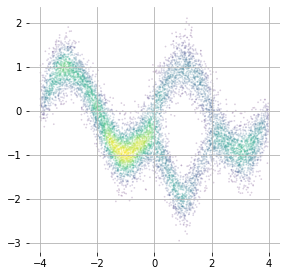

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.019888644033522737

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 14.7 s, sys: 13.1 ms, total: 14.7 s
Wall time: 14.7 s


Scatter plot

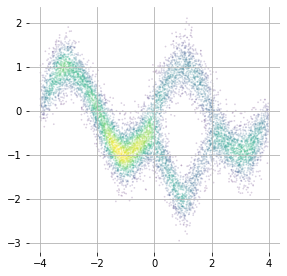

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.020189393805649738

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 4, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

313/313 [==============================] - 3s 902us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = 4, dimension = 2) 

CPU times: user 700 ms, sys: 67.6 ms, total: 768 ms
Wall time: 808 ms


Scatter plot 

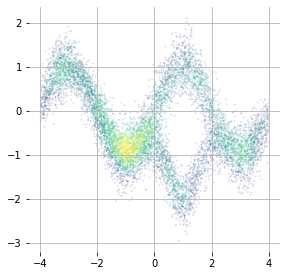

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.03234650573730469

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 4, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

313/313 [==============================] - 0s 1ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = 4, dimension = 2) 

CPU times: user 1.63 s, sys: 137 ms, total: 1.77 s
Wall time: 1.37 s


Scatter plot 

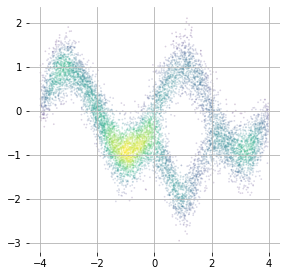

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.031514724731445315

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 4, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

313/313 [==============================] - 0s 1ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = 4, dimension = 2) 

CPU times: user 1min 33s, sys: 2.37 s, total: 1min 35s
Wall time: 51.6 s


Scatter plot 

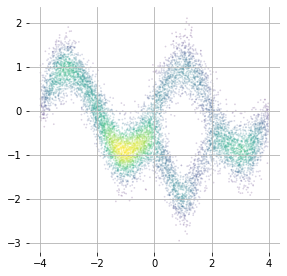

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.022413377380371094

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 4, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

313/313 [==============================] - 1s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = 4, dimension = 2) 

CPU times: user 10min 10s, sys: 3.64 s, total: 10min 13s
Wall time: 5min 15s


Scatter plot 

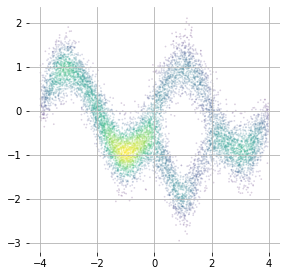

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.022516436767578127

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 4, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

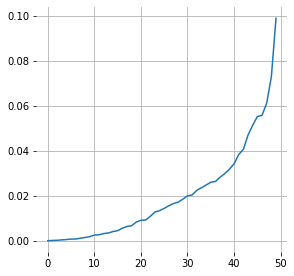

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 4,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 712 ms, sys: 43.4 ms, total: 756 ms
Wall time: 652 ms


Scatter plot 

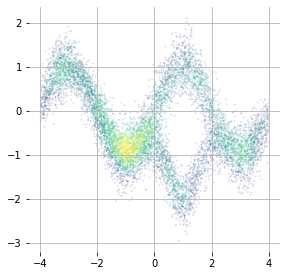

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.03234651489257813

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 4, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

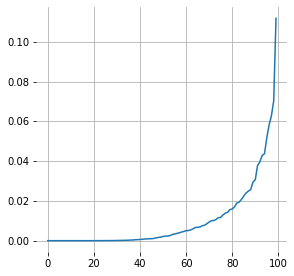

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 4,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 507 ms, sys: 34.2 ms, total: 542 ms
Wall time: 735 ms


Scatter plot 

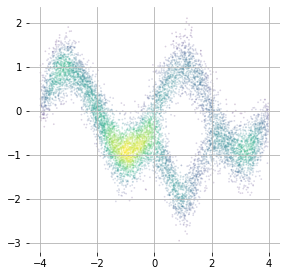

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.03151473693847656

##### dim = 500

Train

In [ ]:
num_eig = 500
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 4, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

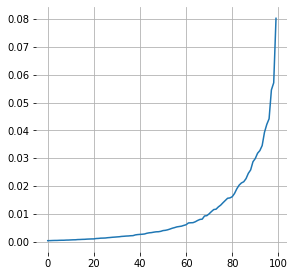

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 4,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 3.5 s, sys: 119 ms, total: 3.61 s
Wall time: 2.21 s


Scatter plot 

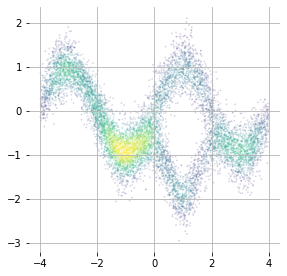

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.02241256561279297

##### dim = 1000

Train

In [ ]:
num_eig = 700
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 4, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

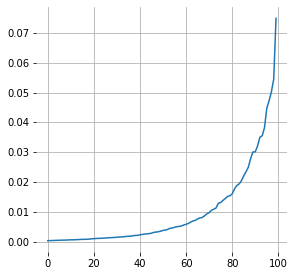

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 4,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 10.4 s, sys: 161 ms, total: 10.6 s
Wall time: 6.13 s


Scatter plot 

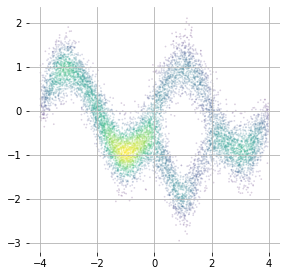

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.022507661437988283

## Experiment 5 : 100000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 100000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(100000, 2) and their densities shape is (100000,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

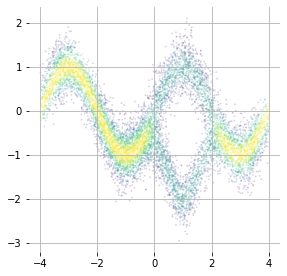

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
#plt.colorbar()
plt.savefig('testdensities_pot3.png',dpi = 300)
plt.show()

### Fixing bandwidth - Use 10.000 bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = pot_3(X_test_new).numpy()
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:32 with L1_error 0.006412727219440295


Fixed gamma

In [ ]:
gamma = 32

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.125

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 34.5 s, sys: 251 ms, total: 34.8 s
Wall time: 34.7 s


Scatter plot

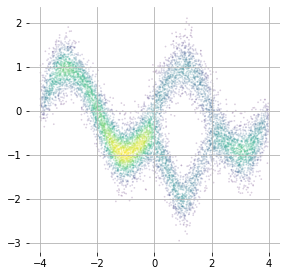

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot3_rawkde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.018267413671176926

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 1min 21s, sys: 149 ms, total: 1min 21s
Wall time: 1min 21s


Scatter plot

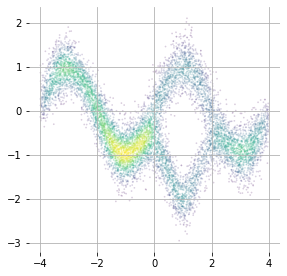

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot3_naivekde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.018267413812446065

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 22.8 s, sys: 118 ms, total: 22.9 s
Wall time: 22.8 s


Scatter plot

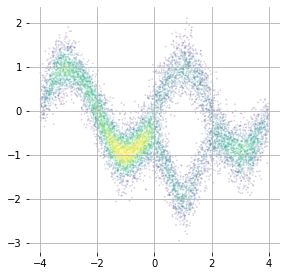

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot3_treekde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.018253850497096387

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 47 s, sys: 102 ms, total: 47.1 s
Wall time: 47 s


Scatter plot

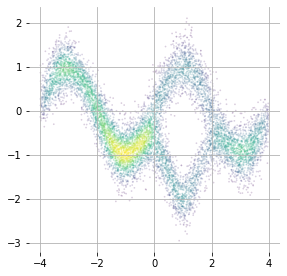

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot3_kerneldensitybtkde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.018267413812417345

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 54.5 s, sys: 206 ms, total: 54.7 s
Wall time: 54.4 s


Scatter plot

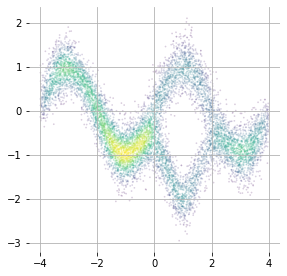

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot3_kerneldensitykdtkde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.018267413812416575

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 15.2 s, sys: 20.6 ms, total: 15.3 s
Wall time: 15.2 s


Scatter plot

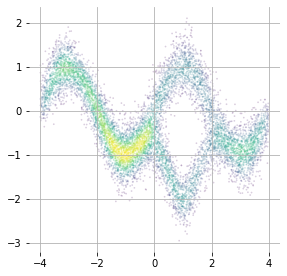

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.019015339817145163

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

3125/3125 [==============================] - 3s 822us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 668 ms, sys: 34.5 ms, total: 703 ms
Wall time: 587 ms


Scatter plot 

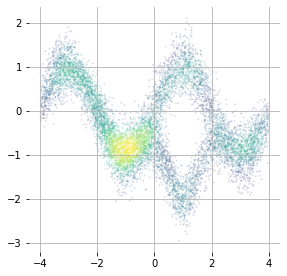

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.025264669799804688

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

3125/3125 [==============================] - 3s 809us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 1.57 s, sys: 195 ms, total: 1.77 s
Wall time: 1.38 s


Scatter plot 

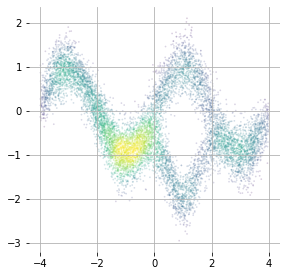

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.027048080444335938

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

3125/3125 [==============================] - 6s 903us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 1min 30s, sys: 3.46 s, total: 1min 33s
Wall time: 51.1 s


Scatter plot 

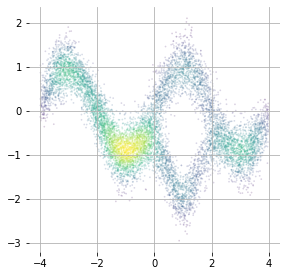

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.029965219116210938

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = 2, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

3125/3125 [==============================] - 11s 3ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = 2, dimension = 2) 

CPU times: user 9min 55s, sys: 7.59 s, total: 10min 2s
Wall time: 5min 13s


Scatter plot 

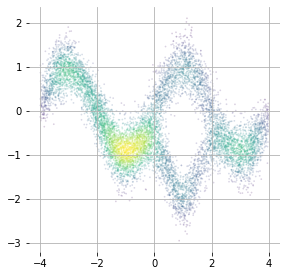

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.03011076354980469

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

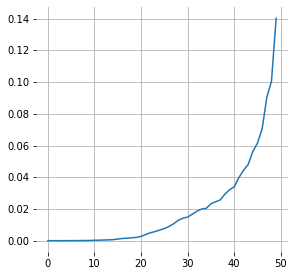

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 442 ms, sys: 39.7 ms, total: 481 ms
Wall time: 374 ms


Scatter plot 

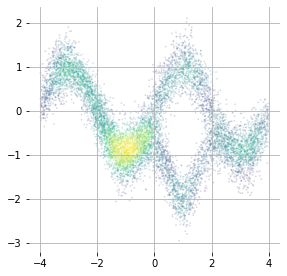

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.025264671325683594

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

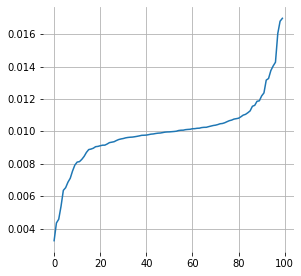

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 769 ms, sys: 40.7 ms, total: 810 ms
Wall time: 1.01 s


Scatter plot 

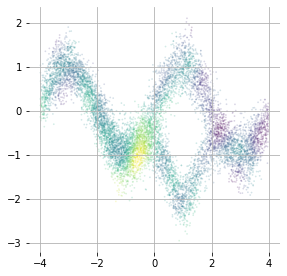

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.07530401611328125

##### dim = 500

Train

In [ ]:
num_eig = 500
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

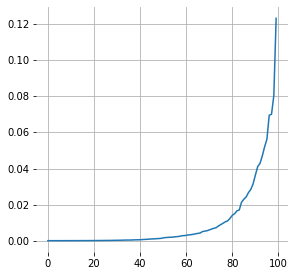

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 3.89 s, sys: 120 ms, total: 4.01 s
Wall time: 2.46 s


Scatter plot 

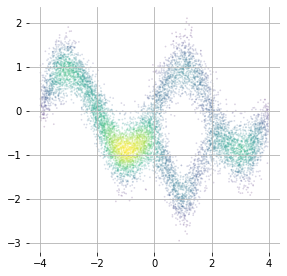

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.02996368408203125

##### dim = 1000

Train

In [ ]:
num_eig = 700
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = 2, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

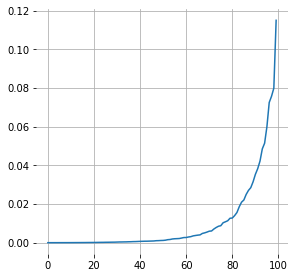

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = 2,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 13.3 s, sys: 267 ms, total: 13.6 s
Wall time: 8.08 s


Scatter plot 

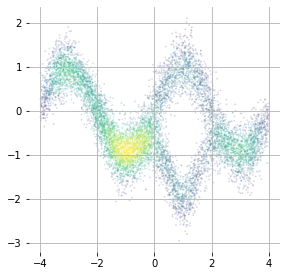

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot3_eigdmkde1000100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.03009693603515625

## Final timing plot

In [ ]:
plt.rcParams["figure.figsize"] = (20*0.75,15*0.75)

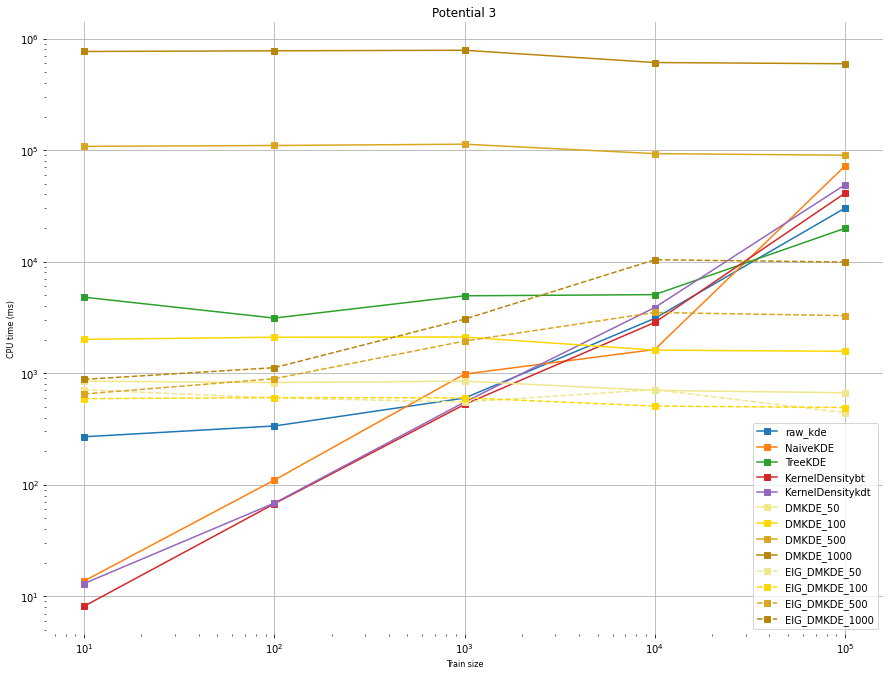

In [ ]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
CPU_time_raw_kde = [269,336,598,3100,30200]
#NaiveKDE
CPU_time_NaiveKDE = [13.7,110,981,1630,72000]
#TreeKDE
CPU_time_TreeKDE = [4800,3120,4940,5060,19900]
#KernelDensitybt
CPU_time_KernelDensitybt = [8.14,67.5,524,2850,41100]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [13,68.4,550,3880,48900]
#fastKDE
#CPU_time_fastKDE = [7430,15000,14300,14700,15200]
#DMKDE_50
CPU_time_DMKDE_50 = [849,824,848,700,668]
#DMKDE_100
CPU_time_DMKDE_100 = [2010,2100,2110,1610,1570]
#DMKDE_500
CPU_time_DMKDE_500 = [108000,110000,113000,93000,90000]
#DMKDE_1000
CPU_time_DMKDE_1000 = [766000,777000,786000,610000,595000]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [711,600,552,712,442]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [591,604,601,507,492]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [651,892,1940,3500,3280]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [880,1120,3050,10400,9920]

plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,CPU_time_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,CPU_time_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,CPU_time_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,CPU_time_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,CPU_time_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,CPU_time_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
plt.plot(train_size,CPU_time_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
plt.plot(train_size,CPU_time_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
plt.plot(train_size,CPU_time_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,CPU_time_DMKDE_1000, c = 'darkgoldenrod', marker = 's', label = 'DMKDE_1000')
plt.plot(train_size,CPU_time_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
plt.plot(train_size,CPU_time_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
plt.plot(train_size,CPU_time_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,CPU_time_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('CPU time (ms)')
plt.title('Potential 3')
plt.savefig('time_pot3.png', dpi=300)
plt.show()

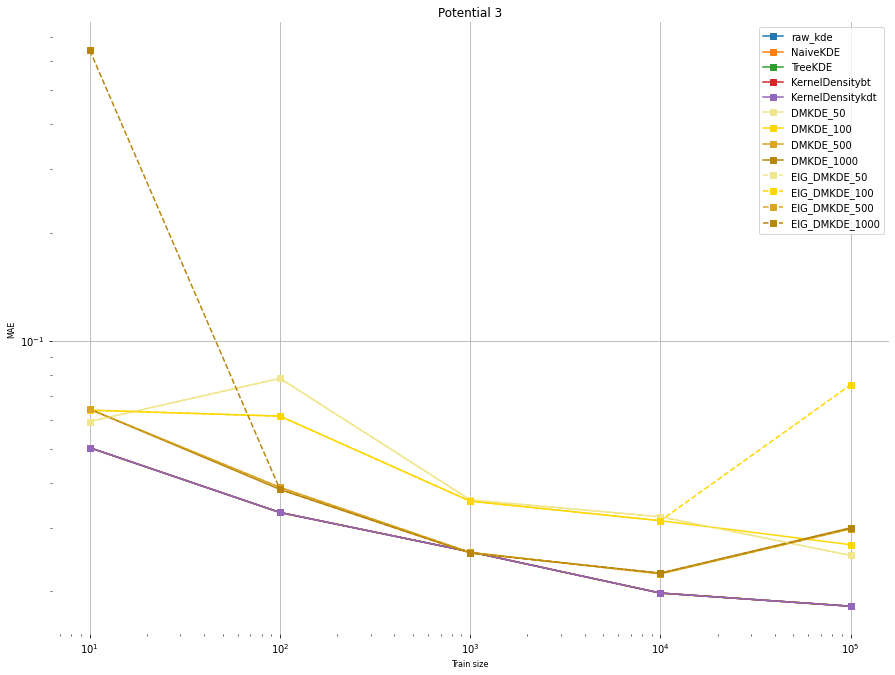

In [ ]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
error_raw_kde = [0.0503,0.0332,0.0258,0.0198,0.0182]
#NaiveKDE
error_NaiveKDE = [0.0503,0.0332,0.0258,0.0198,0.0182]
#TreeKDE
error_TreeKDE = [0.0503,0.0332,0.0258,0.0198,0.0182]
#KernelDensitybt
error_KernelDensitybt = [0.0503,0.0332,0.0258,0.0198,0.0182]
#KernelDensitykdt
error_KernelDensitykdt = [0.0503,0.0332,0.0258,0.0198,0.0182]
#fastKDE
#error_fastKDE = [0.0589,0.0432,0.0267,0.0201,0.0190]
#DMKDE_50
error_DMKDE_50 = [0.0595,0.0785,0.0360,0.0323,0.0252]
#DMKDE_100
error_DMKDE_100 = [0.0640,0.0616,0.0357,0.0315,0.0270]
#DMKDE_500
error_DMKDE_500 = [0.0644,0.0390,0.0257,0.0224,0.0299]
#DMKDE_1000
error_DMKDE_1000 = [0.0644,0.0385,0.0256,0.0225,0.0301]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0595,0.0785,0.0360,0.0323,0.0252]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0640,0.0616,0.0357,0.0315,0.0753]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0644,0.0390,0.0257,0.0224,0.0299]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.644,0.0385,0.0256,0.0225,0.0300]

plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,error_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,error_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,error_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,error_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,error_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,error_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
plt.plot(train_size,error_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
plt.plot(train_size,error_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
plt.plot(train_size,error_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,error_DMKDE_1000, c = 'darkgoldenrod', marker = 's', label = 'DMKDE_1000')
plt.plot(train_size,error_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
plt.plot(train_size,error_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
plt.plot(train_size,error_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,error_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('MAE')
plt.title('Potential 3')
plt.savefig('mae_pot3.png', dpi=300)
plt.show()

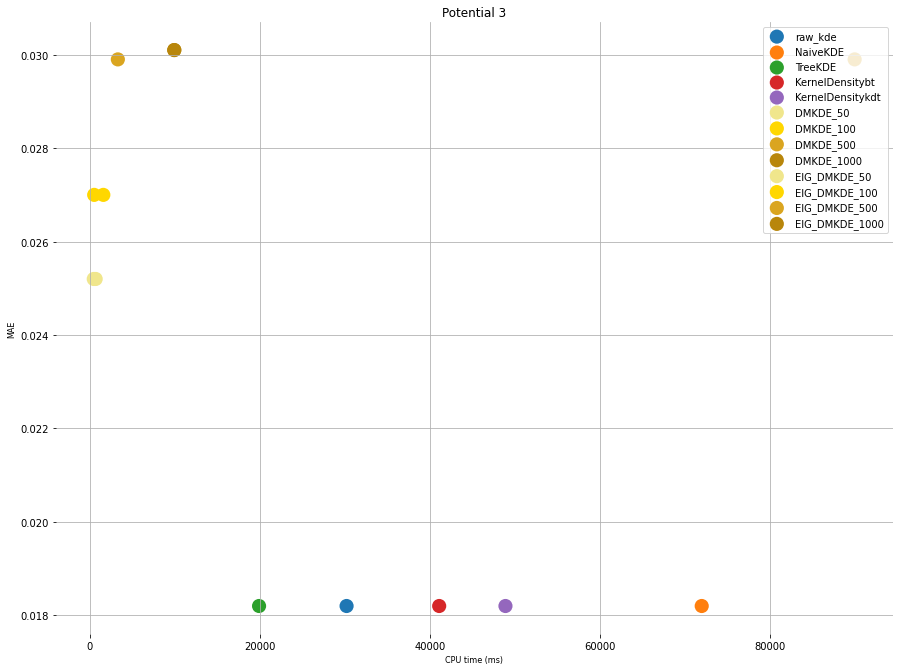

In [ ]:
#raw_kde
CPU_time_raw_kde = [269,336,598,3100,30200][4]
#NaiveKDE
CPU_time_NaiveKDE = [13.7,110,981,1630,72000][4]
#TreeKDE
CPU_time_TreeKDE = [4800,3120,4940,5060,19900][4]
#KernelDensitybt
CPU_time_KernelDensitybt = [8.14,67.5,524,2850,41100][4]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [13,68.4,550,3880,48900][4]
#fastKDE
#CPU_time_fastKDE = [7430,15000,14300,14700,15200][4]
#DMKDE_50
CPU_time_DMKDE_50 = [849,824,848,700,668][4]
#DMKDE_100
CPU_time_DMKDE_100 = [2010,2100,2110,1610,1570][4]
#DMKDE_500
CPU_time_DMKDE_500 = [108000,110000,113000,93000,90000][4]
#DMKDE_1000
CPU_time_DMKDE_1000 = [766000,777000,786000,610000,595000][4]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [711,600,552,712,442][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [591,604,601,507,492][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [651,892,1940,3500,3280][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [880,1120,3050,10400,9920][4]


#raw_kde
error_raw_kde = [0.0503,0.0332,0.0258,0.0198,0.0182][4]
#NaiveKDE
error_NaiveKDE = [0.0503,0.0332,0.0258,0.0198,0.0182][4]
#TreeKDE
error_TreeKDE = [0.0503,0.0332,0.0258,0.0198,0.0182][4]
#KernelDensitybt
error_KernelDensitybt = [0.0503,0.0332,0.0258,0.0198,0.0182][4]
#KernelDensitykdt
error_KernelDensitykdt = [0.0503,0.0332,0.0258,0.0198,0.0182][4]
#fastKDE
#error_fastKDE = [0.0589,0.0432,0.0267,0.0201,0.0190][4]
#DMKDE_50
error_DMKDE_50 = [0.0595,0.0785,0.0360,0.0323,0.0252][4]
#DMKDE_100
error_DMKDE_100 = [0.0640,0.0616,0.0357,0.0315,0.0270][4]
#DMKDE_500
error_DMKDE_500 = [0.0644,0.0390,0.0257,0.0224,0.0299][4]
#DMKDE_1000
error_DMKDE_1000 = [0.0644,0.0385,0.0256,0.0225,0.0301][4]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0595,0.0785,0.0360,0.0323,0.0252][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0640,0.0616,0.0357,0.0315,0.0753][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0644,0.0390,0.0257,0.0224,0.0299][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.644,0.0385,0.0256,0.0225,0.0300][4]

scatter_100m = np.array([[CPU_time_raw_kde,error_raw_kde],
                [CPU_time_NaiveKDE,error_NaiveKDE],
                [CPU_time_TreeKDE,error_TreeKDE],
                [CPU_time_KernelDensitybt,error_KernelDensitybt],
                [CPU_time_KernelDensitykdt,error_KernelDensitykdt],
                [CPU_time_DMKDE_50,error_DMKDE_50],
                [CPU_time_DMKDE_100,error_DMKDE_100],
                [CPU_time_DMKDE_500,error_DMKDE_500],
                [CPU_time_EIG_DMKDE_1000,error_DMKDE_1000],
                [CPU_time_EIG_DMKDE_50,error_DMKDE_50],
                [CPU_time_EIG_DMKDE_100,error_DMKDE_100],
                [CPU_time_EIG_DMKDE_500,error_DMKDE_500],
                [CPU_time_EIG_DMKDE_1000,error_DMKDE_1000]
                ]).T

labels = ['raw_kde','NaiveKDE','TreeKDE','KernelDensitybt','KernelDensitykdt','DMKDE_50','DMKDE_100','DMKDE_500','DMKDE_1000','EIG_DMKDE_50','EIG_DMKDE_100'
,'EIG_DMKDE_500','EIG_DMKDE_1000']

colors = np.array(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','khaki','gold','goldenrod','darkgoldenrod','khaki','gold','goldenrod','darkgoldenrod'])

#
fig, ax = plt.subplots()
j=0
for color,label in zip(colors,labels):
    x, y = (scatter_100m[0][j],scatter_100m[1][j])
    ax.grid(True)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.scatter(x, y, c= color, label= label,s = 200, edgecolors='none')
    j+=1
ax.set_xlabel('CPU time (ms)')
ax.set_ylabel('MAE')
ax.set_title('Potential 3')
ax.grid(b=True)
ax.legend(loc = 1)
fig.savefig('eff_pot3.png', dpi=300)

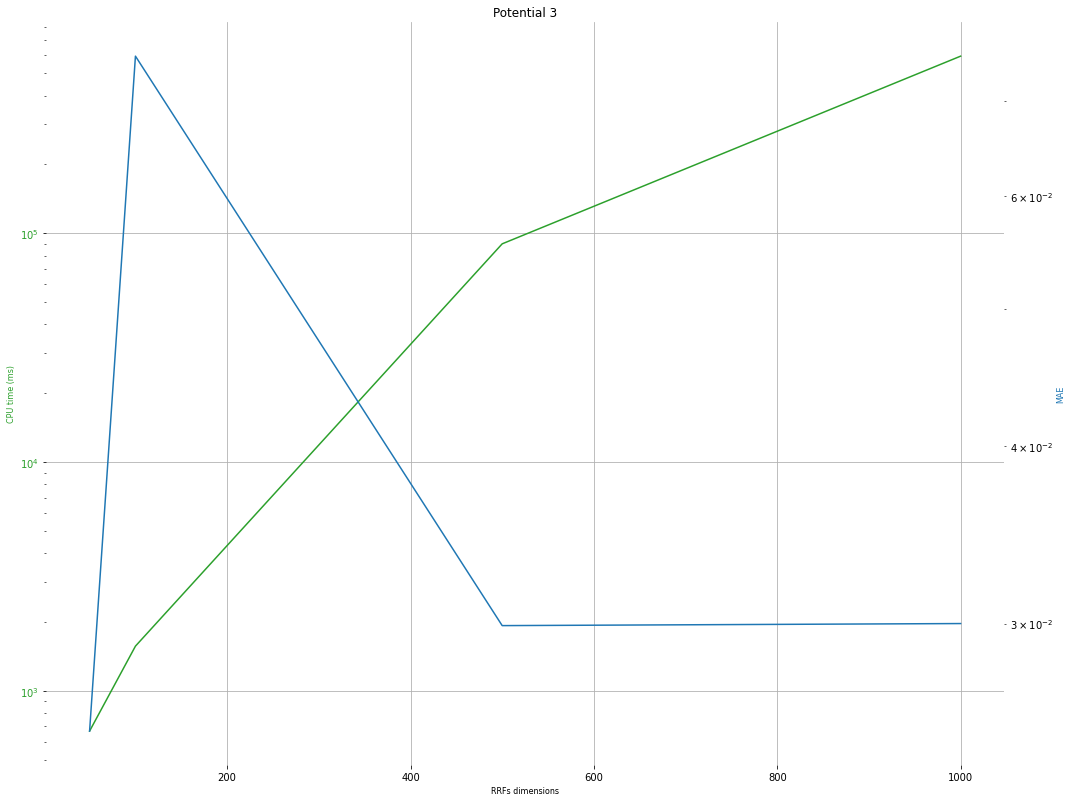

In [ ]:
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [711,600,552,712,442][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [591,604,601,507,492][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [651,892,1940,3500,3280][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [880,1120,3050,10400,9920][4]

#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0595,0.0785,0.0360,0.0323,0.0252][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0640,0.0616,0.0357,0.0315,0.0753][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0644,0.0390,0.0257,0.0224,0.0299][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.644,0.0385,0.0256,0.0225,0.0300][4]
t = [50.,100.,500.,1000.]
data1 = [CPU_time_DMKDE_50,CPU_time_DMKDE_100,CPU_time_DMKDE_500,CPU_time_DMKDE_1000]
data2 = [error_EIG_DMKDE_50,error_EIG_DMKDE_100,error_EIG_DMKDE_500,error_EIG_DMKDE_1000]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_title('Potential 3')
ax1.grid(True)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.set_xlabel('RRFs dimensions')
ax1.set_ylabel('CPU time (ms)', color=color)
ax1.set_yscale('log')
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.grid(True)
ax2.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.set_ylabel('MAE', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('rff_pot3.png', dpi=300)
plt.show()

## Final timing plot

In [10]:
!pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6484 sha256=9a76808e33db5b66f32b0b1137271b6783a338102e771e4342bd63b621e301ee
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots


In [11]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
!pip install latex

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [12]:
plt.style.reload_library()
plt.style.use(['science','ieee','no-latex'])

In [13]:
size = (5,4)

In [14]:
plt.rcParams["figure.figsize"] = size

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


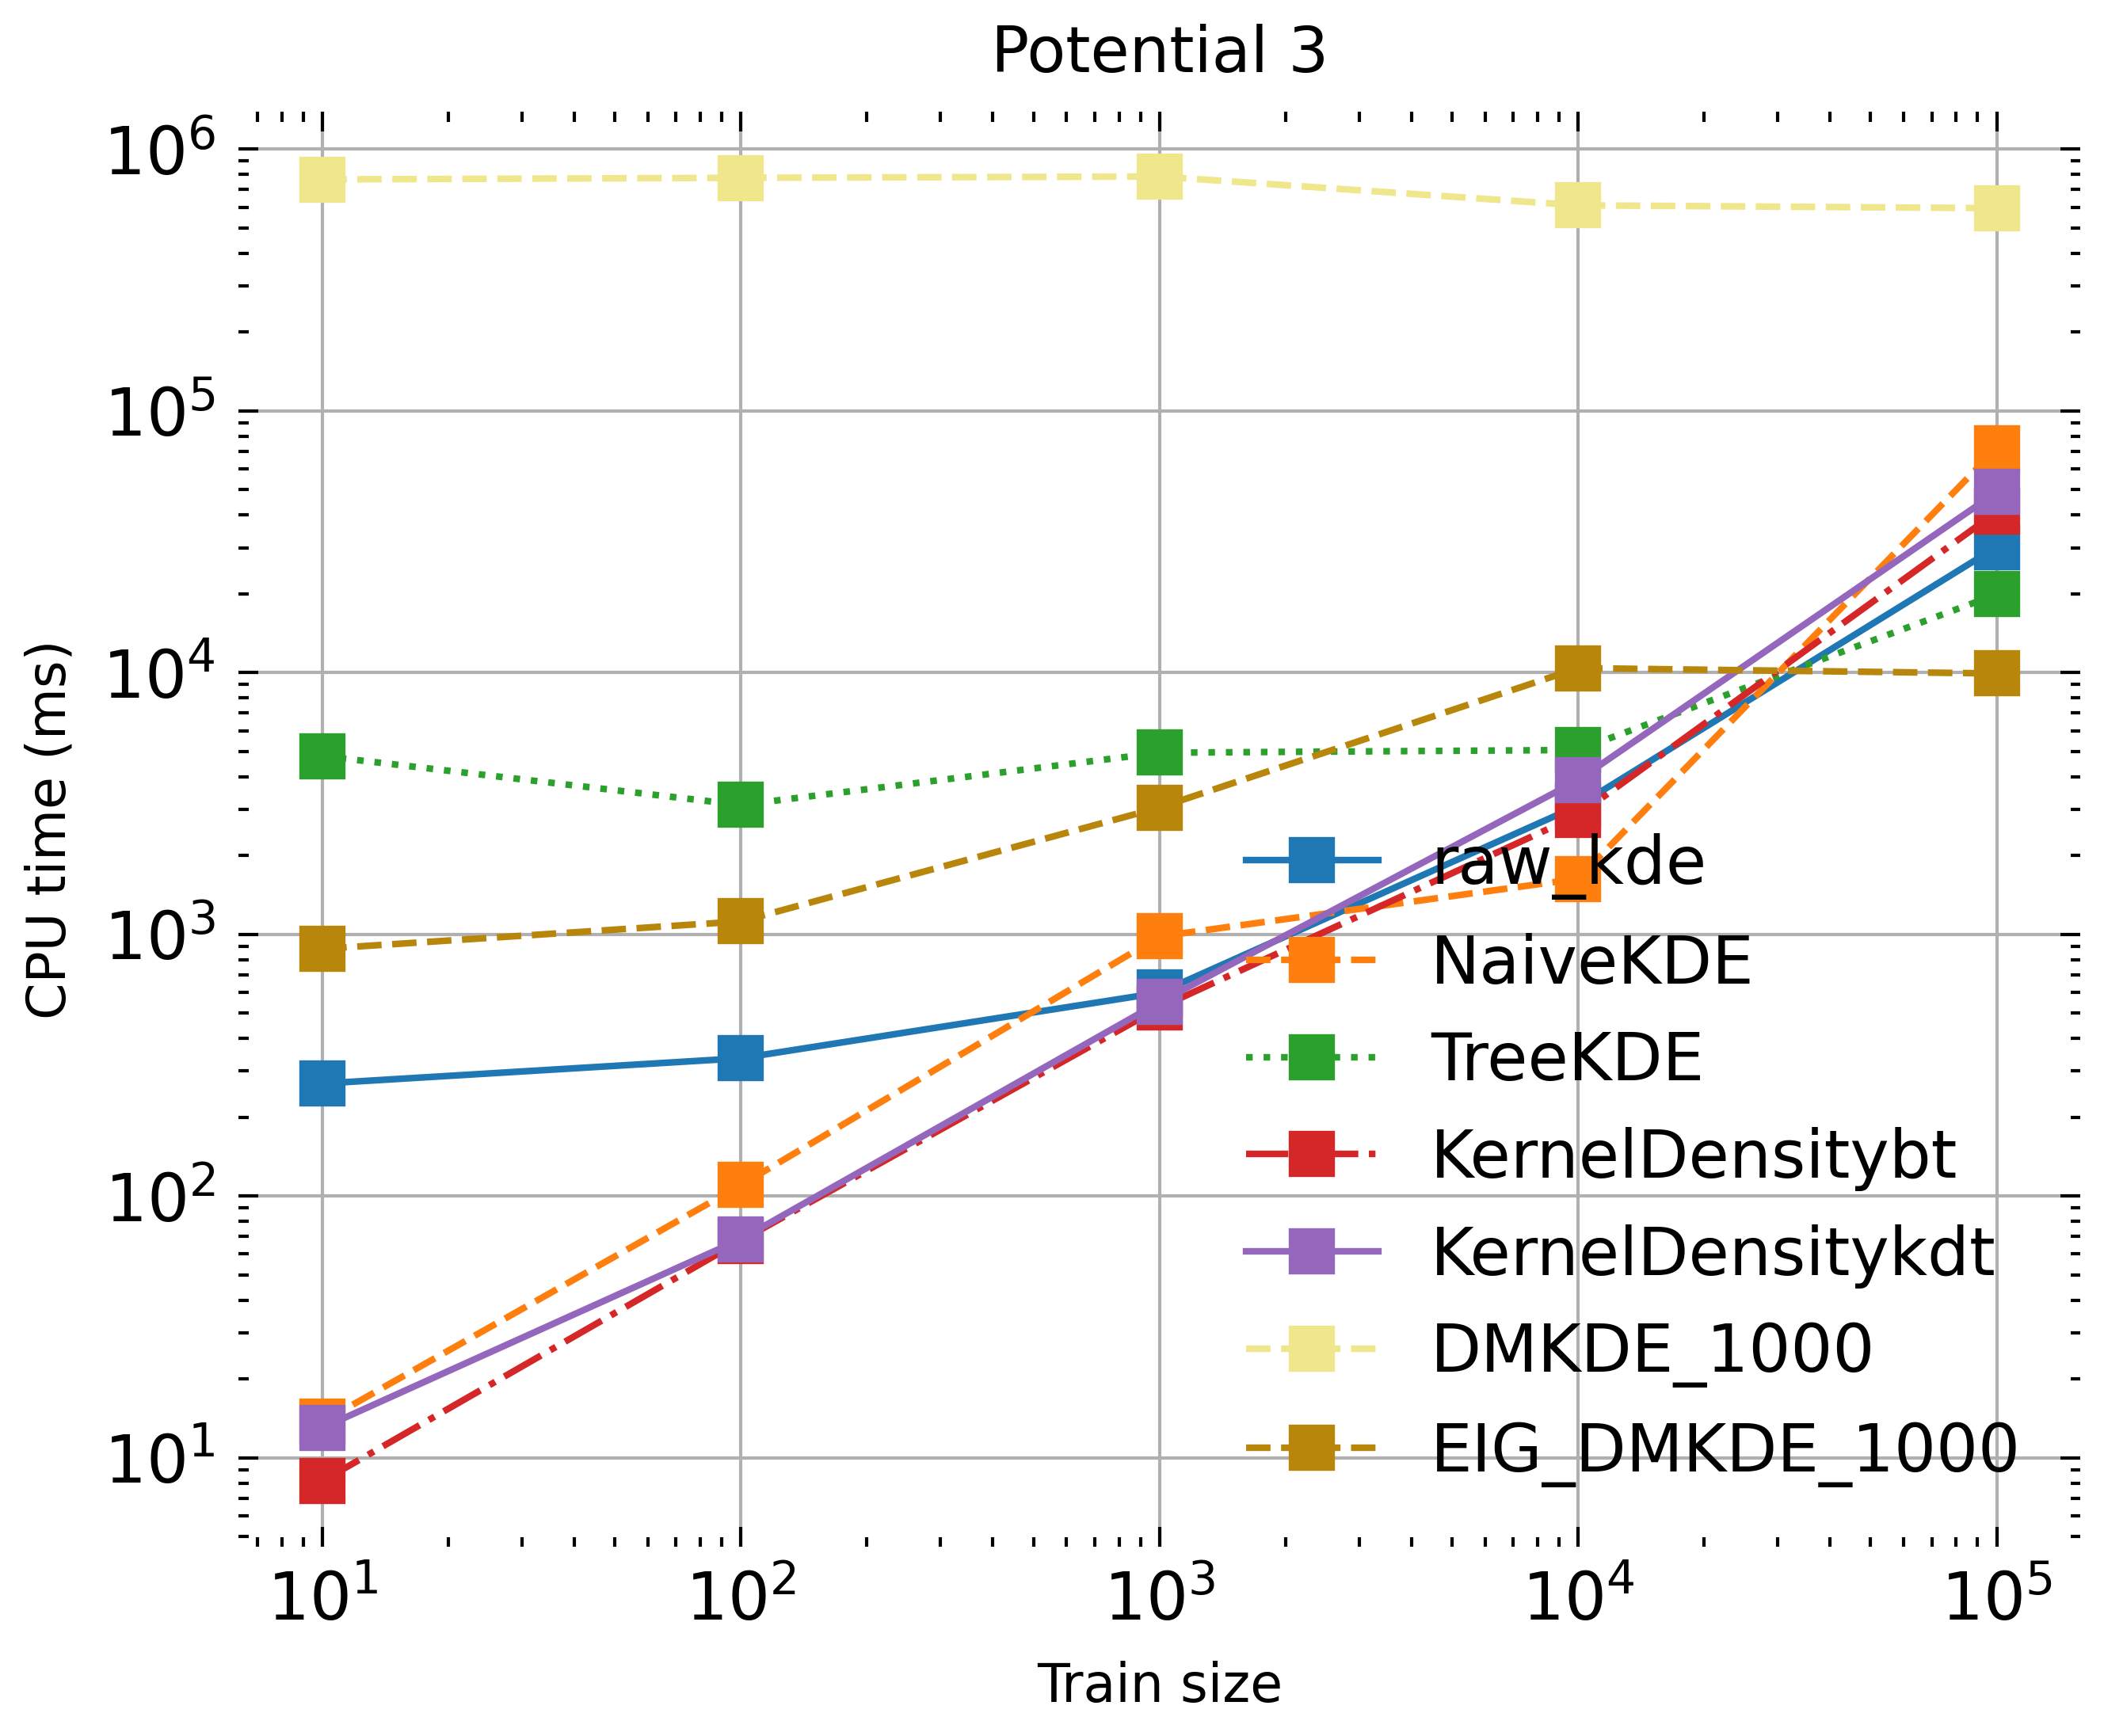

In [15]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
CPU_time_raw_kde = [269,336,598,3100,30200]
#NaiveKDE
CPU_time_NaiveKDE = [13.7,110,981,1630,72000]
#TreeKDE
CPU_time_TreeKDE = [4800,3120,4940,5060,19900]
#KernelDensitybt
CPU_time_KernelDensitybt = [8.14,67.5,524,2850,41100]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [13,68.4,550,3880,48900]
#fastKDE
#CPU_time_fastKDE = [7430,15000,14300,14700,15200]
#DMKDE_50
CPU_time_DMKDE_50 = [849,824,848,700,668]
#DMKDE_100
CPU_time_DMKDE_100 = [2010,2100,2110,1610,1570]
#DMKDE_500
CPU_time_DMKDE_500 = [108000,110000,113000,93000,90000]
#DMKDE_1000
CPU_time_DMKDE_1000 = [766000,777000,786000,610000,595000]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [711,600,552,712,442]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [591,604,601,507,492]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [651,892,1940,3500,3280]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [880,1120,3050,10400,9920]

plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,CPU_time_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,CPU_time_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,CPU_time_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,CPU_time_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,CPU_time_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,CPU_time_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
#plt.plot(train_size,CPU_time_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
#plt.plot(train_size,CPU_time_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
#plt.plot(train_size,CPU_time_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,CPU_time_DMKDE_1000, c = 'khaki', marker = 's', label = 'DMKDE_1000')
#plt.plot(train_size,CPU_time_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
#plt.plot(train_size,CPU_time_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
#plt.plot(train_size,CPU_time_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,CPU_time_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('CPU time (ms)')
plt.title('Potential 3')
plt.savefig('time_pot3.png', dpi=300)
plt.show()

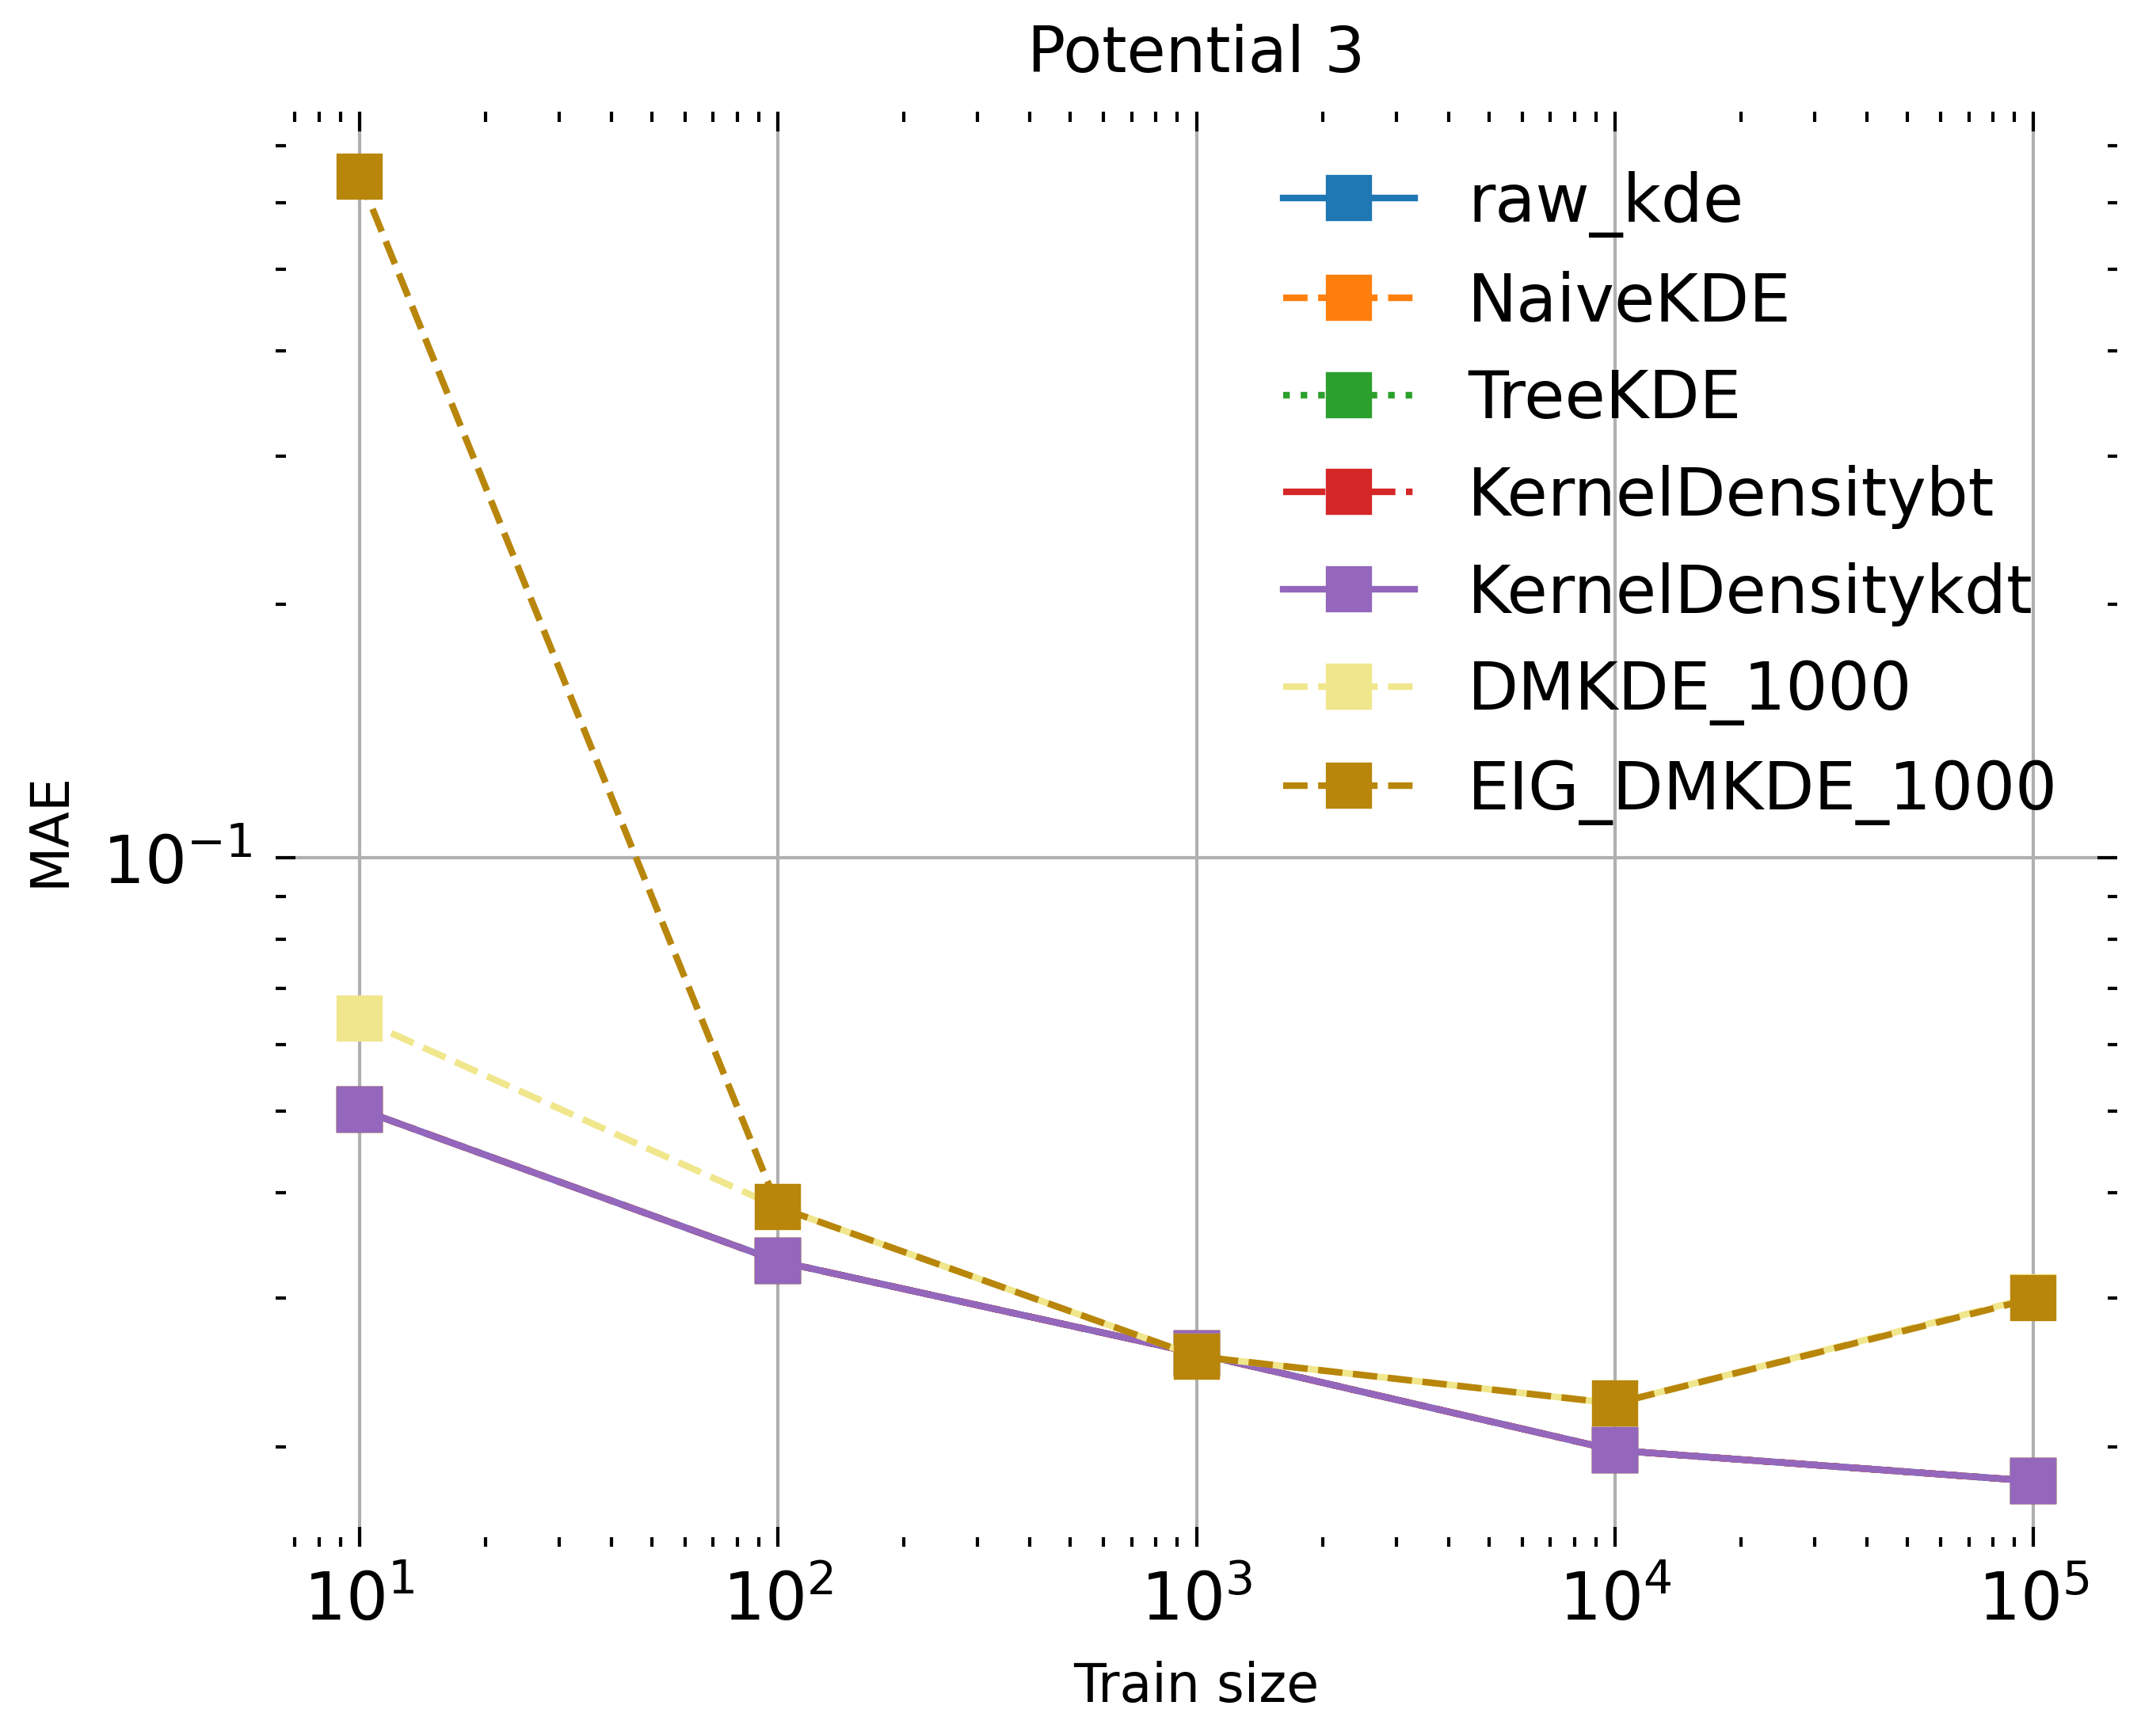

In [16]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
error_raw_kde = [0.0503,0.0332,0.0258,0.0198,0.0182]
#NaiveKDE
error_NaiveKDE = [0.0503,0.0332,0.0258,0.0198,0.0182]
#TreeKDE
error_TreeKDE = [0.0503,0.0332,0.0258,0.0198,0.0182]
#KernelDensitybt
error_KernelDensitybt = [0.0503,0.0332,0.0258,0.0198,0.0182]
#KernelDensitykdt
error_KernelDensitykdt = [0.0503,0.0332,0.0258,0.0198,0.0182]
#fastKDE
#error_fastKDE = [0.0589,0.0432,0.0267,0.0201,0.0190]
#DMKDE_50
error_DMKDE_50 = [0.0595,0.0785,0.0360,0.0323,0.0252]
#DMKDE_100
error_DMKDE_100 = [0.0640,0.0616,0.0357,0.0315,0.0270]
#DMKDE_500
error_DMKDE_500 = [0.0644,0.0390,0.0257,0.0224,0.0299]
#DMKDE_1000
error_DMKDE_1000 = [0.0644,0.0385,0.0256,0.0225,0.0301]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0595,0.0785,0.0360,0.0323,0.0252]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0640,0.0616,0.0357,0.0315,0.0753]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0644,0.0390,0.0257,0.0224,0.0299]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.644,0.0385,0.0256,0.0225,0.0300]

plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,error_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,error_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,error_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,error_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,error_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,error_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
#plt.plot(train_size,error_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
#plt.plot(train_size,error_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
#plt.plot(train_size,error_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,error_DMKDE_1000, c = 'khaki', marker = 's', label = 'DMKDE_1000')
#plt.plot(train_size,error_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
#plt.plot(train_size,error_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
#plt.plot(train_size,error_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,error_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('MAE')
plt.title('Potential 3')
plt.savefig('mae_pot3.png', dpi=300)
plt.show()

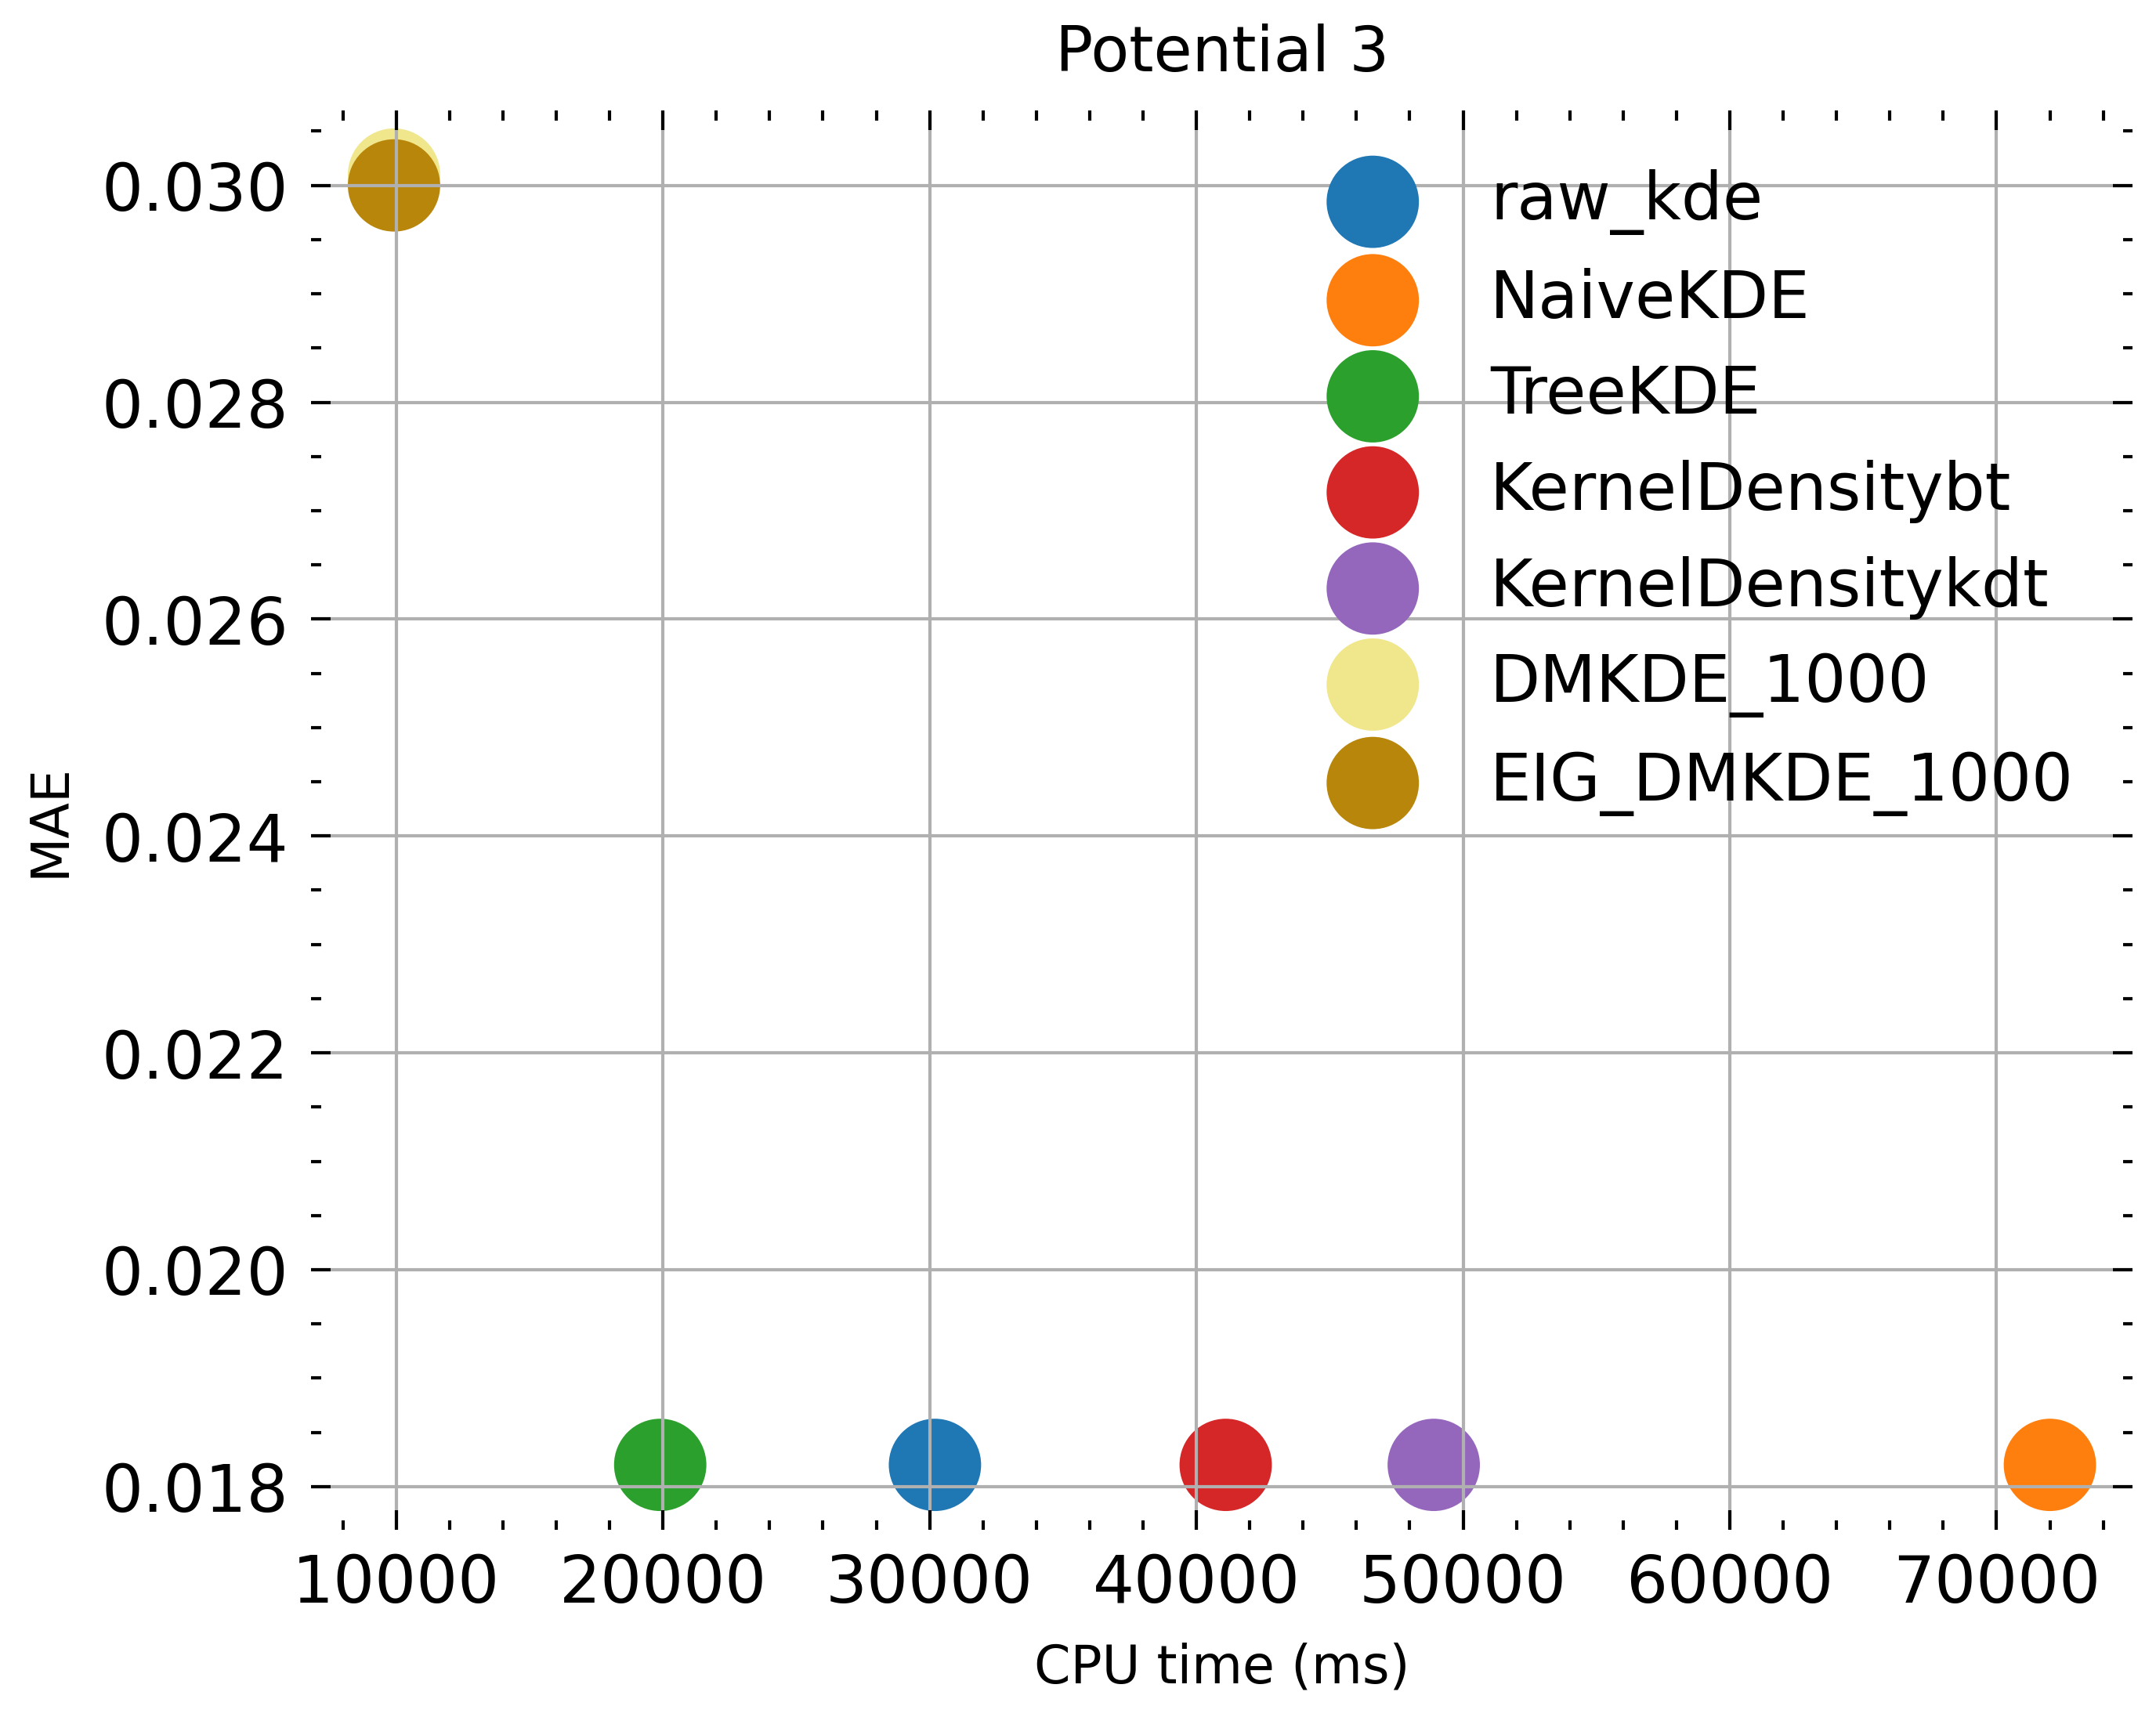

In [17]:
#raw_kde
CPU_time_raw_kde = [269,336,598,3100,30200][4]
#NaiveKDE
CPU_time_NaiveKDE = [13.7,110,981,1630,72000][4]
#TreeKDE
CPU_time_TreeKDE = [4800,3120,4940,5060,19900][4]
#KernelDensitybt
CPU_time_KernelDensitybt = [8.14,67.5,524,2850,41100][4]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [13,68.4,550,3880,48900][4]
#fastKDE
#CPU_time_fastKDE = [7430,15000,14300,14700,15200][4]
#DMKDE_50
CPU_time_DMKDE_50 = [849,824,848,700,668][4]
#DMKDE_100
CPU_time_DMKDE_100 = [2010,2100,2110,1610,1570][4]
#DMKDE_500
CPU_time_DMKDE_500 = [108000,110000,113000,93000,90000][4]
#DMKDE_1000
CPU_time_DMKDE_1000 = [766000,777000,786000,610000,595000][4]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [711,600,552,712,442][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [591,604,601,507,492][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [651,892,1940,3500,3280][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [880,1120,3050,10400,9920][4]


#raw_kde
error_raw_kde = [0.0503,0.0332,0.0258,0.0198,0.0182][4]
#NaiveKDE
error_NaiveKDE = [0.0503,0.0332,0.0258,0.0198,0.0182][4]
#TreeKDE
error_TreeKDE = [0.0503,0.0332,0.0258,0.0198,0.0182][4]
#KernelDensitybt
error_KernelDensitybt = [0.0503,0.0332,0.0258,0.0198,0.0182][4]
#KernelDensitykdt
error_KernelDensitykdt = [0.0503,0.0332,0.0258,0.0198,0.0182][4]
#fastKDE
#error_fastKDE = [0.0589,0.0432,0.0267,0.0201,0.0190][4]
#DMKDE_50
error_DMKDE_50 = [0.0595,0.0785,0.0360,0.0323,0.0252][4]
#DMKDE_100
error_DMKDE_100 = [0.0640,0.0616,0.0357,0.0315,0.0270][4]
#DMKDE_500
error_DMKDE_500 = [0.0644,0.0390,0.0257,0.0224,0.0299][4]
#DMKDE_1000
error_DMKDE_1000 = [0.0644,0.0385,0.0256,0.0225,0.0301][4]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0595,0.0785,0.0360,0.0323,0.0252][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0640,0.0616,0.0357,0.0315,0.0753][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0644,0.0390,0.0257,0.0224,0.0299][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.644,0.0385,0.0256,0.0225,0.0300][4]

scatter_100m ={"raw_kde": [CPU_time_raw_kde,error_raw_kde],
                'NaiveKDE':[CPU_time_NaiveKDE,error_NaiveKDE],
                'TreeKDE':[CPU_time_TreeKDE,error_TreeKDE],
                'KernelDensitybt':[CPU_time_KernelDensitybt,error_KernelDensitybt],
                'KernelDensitykdt':[CPU_time_KernelDensitykdt,error_KernelDensitykdt],
                'DMKDE_50':[CPU_time_DMKDE_50,error_DMKDE_50],
                'DMKDE_100':[CPU_time_DMKDE_100,error_DMKDE_100],
                'DMKDE_500':[CPU_time_DMKDE_500,error_DMKDE_500],
                'DMKDE_1000':[CPU_time_EIG_DMKDE_1000,error_DMKDE_1000],
                'EIG_DMKDE_50':[CPU_time_EIG_DMKDE_50,error_EIG_DMKDE_50],
                'EIG_DMKDE_100':[CPU_time_EIG_DMKDE_100,error_EIG_DMKDE_100],
                'EIG_DMKDE_500':[CPU_time_EIG_DMKDE_500,error_EIG_DMKDE_500],
                'EIG_DMKDE_1000':[CPU_time_EIG_DMKDE_1000,error_EIG_DMKDE_1000]
          }

labels = ['raw_kde','NaiveKDE','TreeKDE','KernelDensitybt','KernelDensitykdt','DMKDE_1000', 'EIG_DMKDE_1000']

colors = np.array(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','khaki','darkgoldenrod'])
#
fig, ax = plt.subplots()
for color,label in zip(colors,labels):
    x, y = (scatter_100m[label][0],scatter_100m[label][1])
    ax.grid(True)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.scatter(x, y, c= color, label= label,s = 200, edgecolors='none')
ax.set_xlabel('CPU time (ms)')
ax.set_ylabel('MAE')
ax.set_title('Potential 3')
ax.grid(b=True)
ax.legend(loc = 1)
fig.savefig('eff_pot3.png', dpi=300)

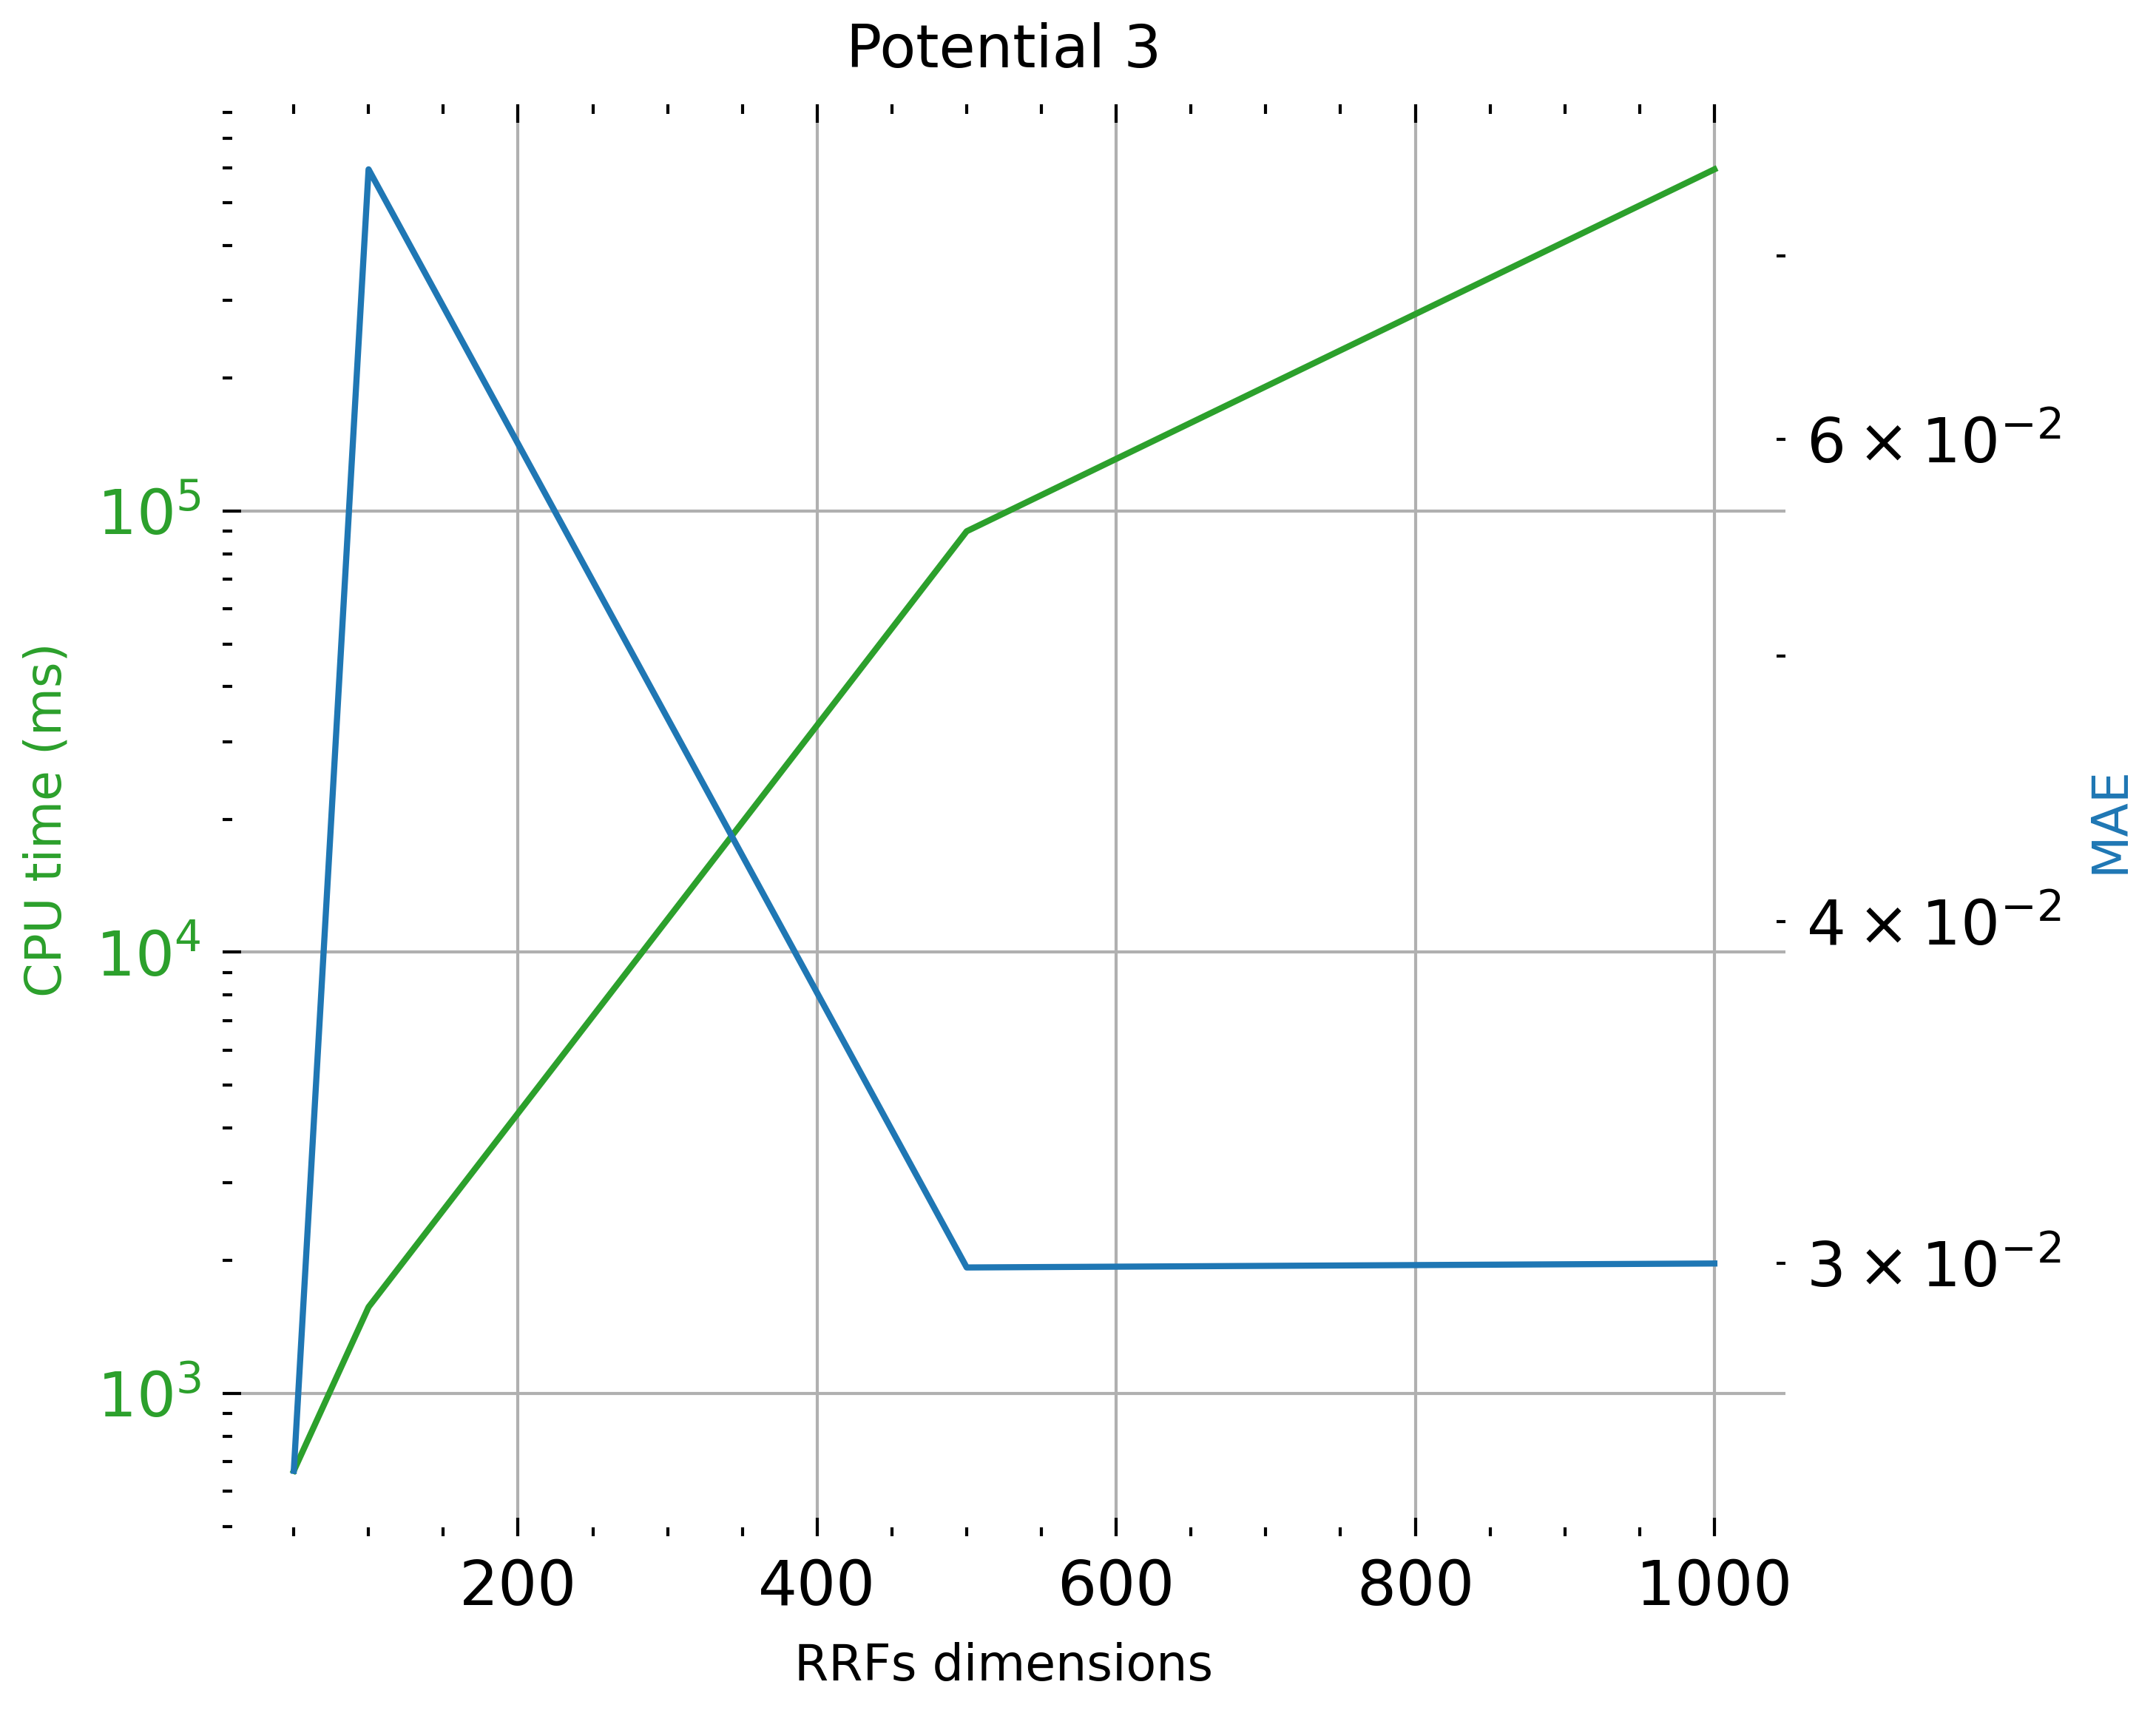

In [18]:
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [711,600,552,712,442][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [591,604,601,507,492][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [651,892,1940,3500,3280][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [880,1120,3050,10400,9920][4]

#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0595,0.0785,0.0360,0.0323,0.0252][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0640,0.0616,0.0357,0.0315,0.0753][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0644,0.0390,0.0257,0.0224,0.0299][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.644,0.0385,0.0256,0.0225,0.0300][4]
t = [50.,100.,500.,1000.]
data1 = [CPU_time_DMKDE_50,CPU_time_DMKDE_100,CPU_time_DMKDE_500,CPU_time_DMKDE_1000]
data2 = [error_EIG_DMKDE_50,error_EIG_DMKDE_100,error_EIG_DMKDE_500,error_EIG_DMKDE_1000]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_title('Potential 3')
ax1.grid(True)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.set_xlabel('RRFs dimensions')
ax1.set_ylabel('CPU time (ms)', color=color)
ax1.set_yscale('log')
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.grid(True)
ax2.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.set_ylabel('MAE', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('rff_pot3.png', dpi=300)
plt.show()